In [1]:
from hipe4ml.model_handler import ModelHandler
from sklearn.utils.class_weight import compute_sample_weight
from load_data import LoadData
from prepare_model import PrepareModel
import plotting_tools
from train_model import TrainModel

In [2]:
loader = LoadData("/Users/julnow/gsi/mgr/trees/PlainTree2M_DCM_tof_primaries_12agev.root", "config.json", 3.4, 12, False)

In [3]:
tree_handler = loader.load_tree(max_workers=8)


Loading tree from /Users/julnow/gsi/mgr/trees/PlainTree2M_DCM_tof_primaries_12agev.root...


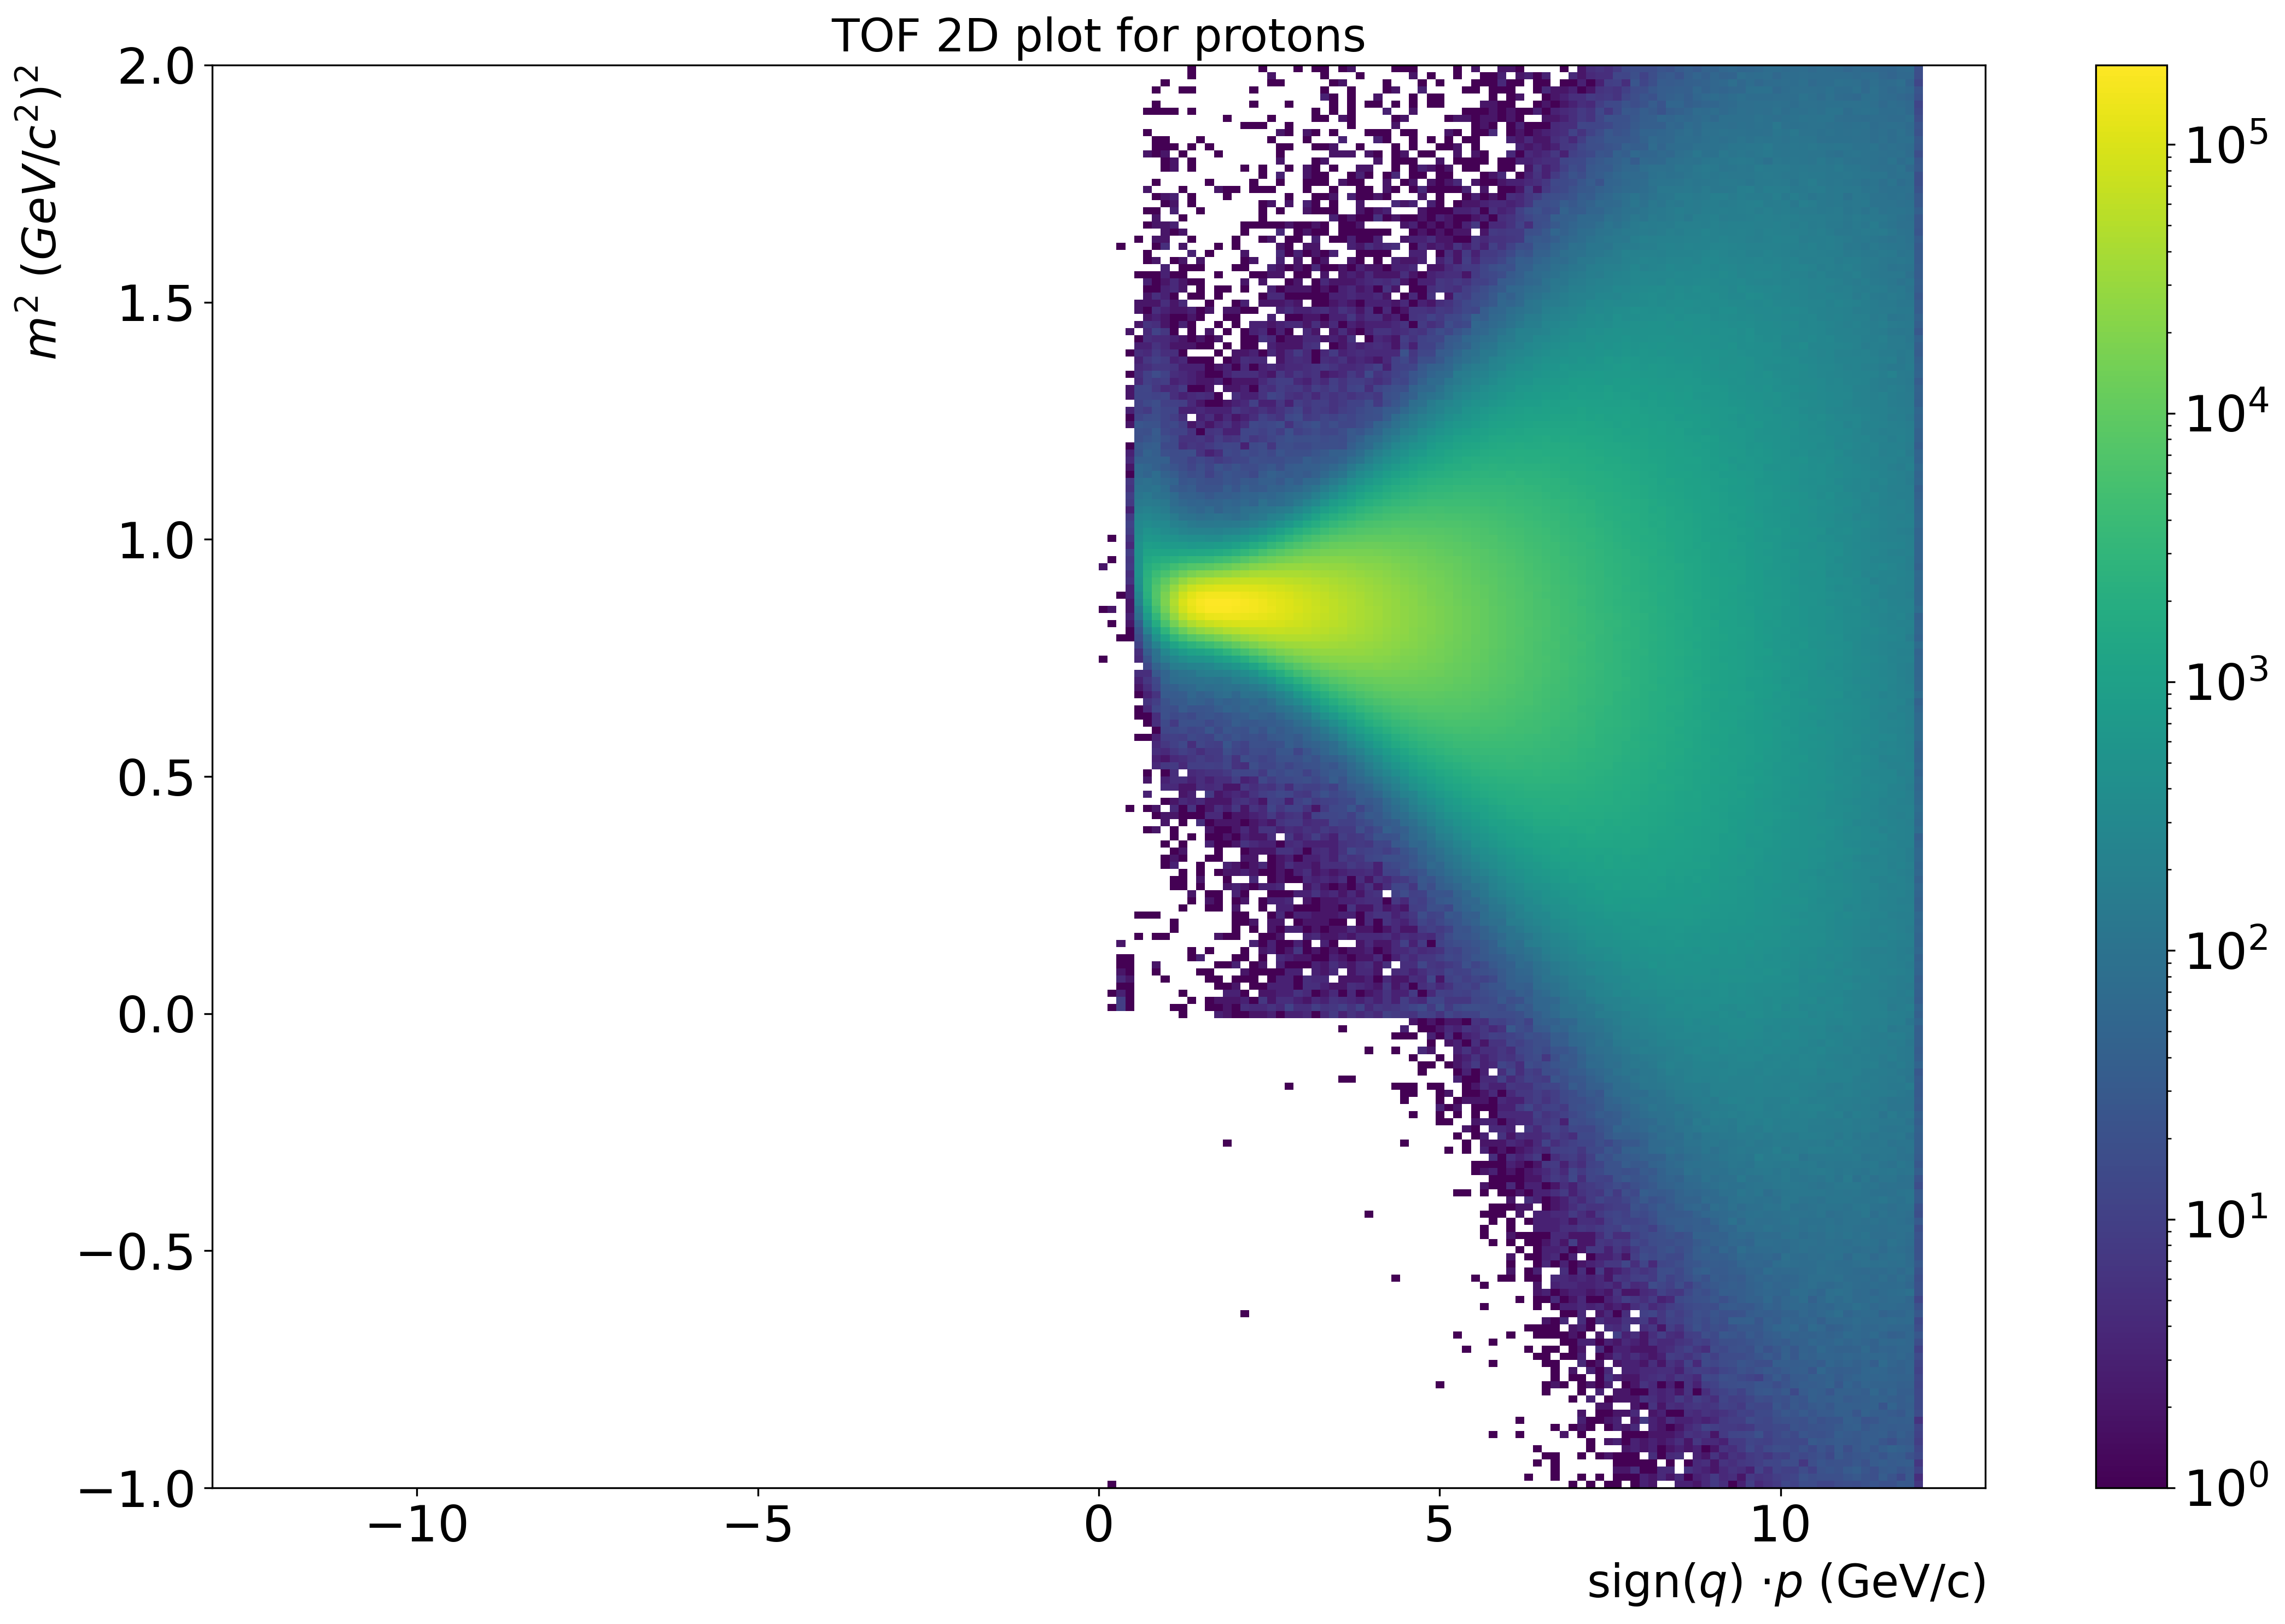

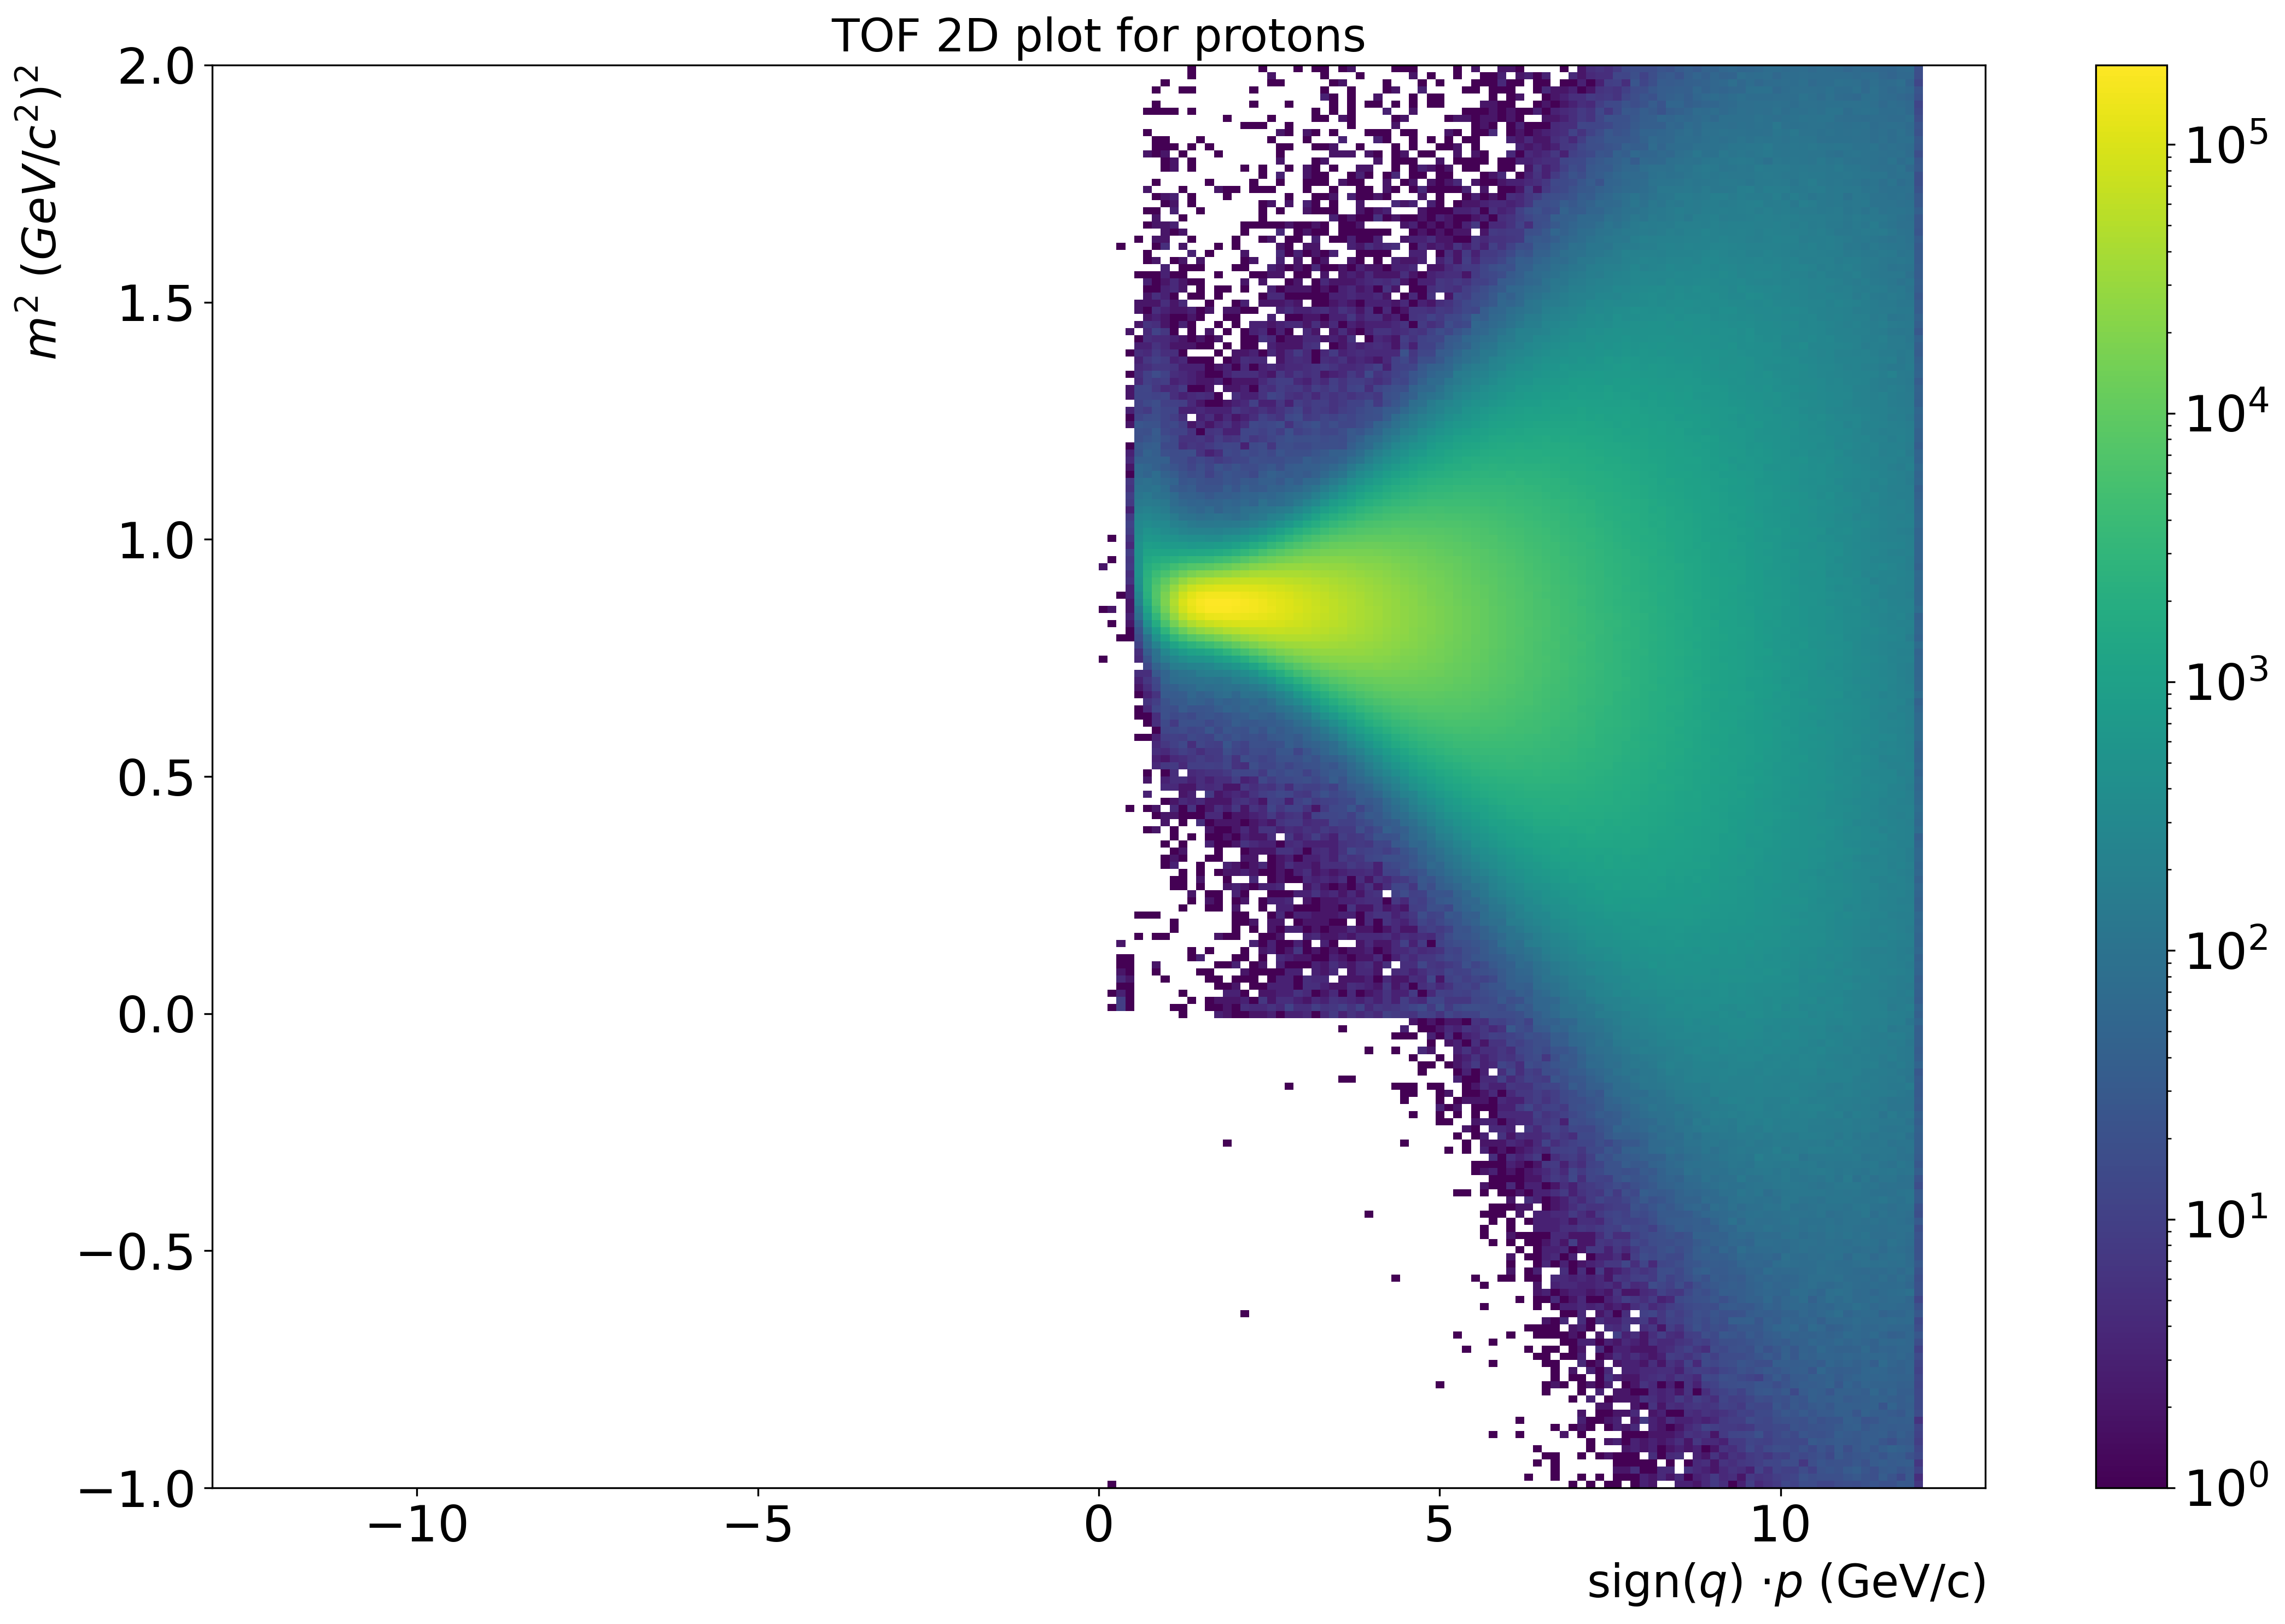

In [4]:
from particles_id import ParticlesId as Pid
df = tree_handler.get_data_frame()
df = df[df["Complex_pid"] == Pid.PROTON.value]
plotting_tools.tof_plot(df, "config.json", "protons", save_fig=False)


In [4]:
from particles_id import ParticlesId as Pid
import numpy as np
import pandas as pd

In [7]:

df = tree_handler.get_data_frame()
df = df[df["Complex_pid"] == Pid.POS_KAON.value]
momentum = df['Complex_p'].values

num_bins = 3  # Number of desired bins
num_observations = len(momentum)
bin_size = num_observations // num_bins

sorted_momentum = np.sort(momentum)

# Calculate the bin edges
bin_edges = [sorted_momentum[i * bin_size] for i in range(num_bins)]
bin_edges.append(sorted_momentum[-1])

# Determine the minimum and maximum momentum values for each bin
bins = []
for i in range(num_bins):
    bin_min = bin_edges[i]
    bin_max = bin_edges[i + 1]
    bins.append((bin_min, bin_max))

# Print the bins and their respective momentum ranges
for i, bin_range in enumerate(bins):
    print(f"Bin {i+1}: Momentum Range {bin_range}")

Bin 1: Momentum Range (3.4000003, 3.9793541)
Bin 2: Momentum Range (3.9793541, 4.9258246)
Bin 3: Momentum Range (4.9258246, 11.991839)


In [6]:

df = tree_handler.get_data_frame()
df = df[df["Complex_pid"] == Pid.POS_PION.value]
momentum = df['Complex_p'].values

num_bins = 4  # Number of desired bins
num_observations = len(momentum)
bin_size = num_observations // num_bins

sorted_momentum = np.sort(momentum)

# Calculate the bin edges
bin_edges = [sorted_momentum[i * bin_size] for i in range(num_bins)]
bin_edges.append(sorted_momentum[-1])

# Determine the minimum and maximum momentum values for each bin
bins = []
for i in range(num_bins):
    bin_min = bin_edges[i]
    bin_max = bin_edges[i + 1]
    bins.append((bin_min, bin_max))

# Print the bins and their respective momentum ranges
for i, bin_range in enumerate(bins):
    print(f"Bin {i+1}: Momentum Range {bin_range}")

Bin 1: Momentum Range (0.08585883, 0.9528755)
Bin 2: Momentum Range (0.9528755, 1.3829786)
Bin 3: Momentum Range (1.3829786, 1.961072)
Bin 4: Momentum Range (1.961072, 2.9999988)


(array([  39050.,  825872., 1657357., 1725432., 1491643., 1232400.,
        1000096.,  797704.,  635160.,  507620.]),
 array([0.08585883, 0.37727281, 0.66868681, 0.96010083, 1.25151479,
        1.54292881, 1.83434284, 2.12575674, 2.41717076, 2.70858479,
        2.99999881]),
 <BarContainer object of 10 artists>)

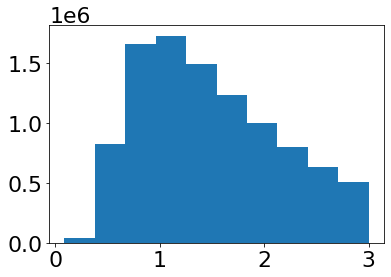

In [8]:
import matplotlib.pyplot as plt 
plt.hist(df[df["Complex_pid"] == Pid.POS_PION.value]["Complex_p"])

In [2]:
json_file_name = "config.json"
lower_p_cut, upper_p_cut = 6, 8
anti_particles = False
optimize_hyper_params = False
create_plots = True
save_plots = False
if anti_particles:
    model_name = f"model_{lower_p_cut:.1f}_{upper_p_cut:.1f}_anti"
else:
    model_name = f"model_{lower_p_cut:.1f}_{upper_p_cut:.1f}_positive"
data_file_name = LoadData.load_file_name(json_file_name, "training")

# loading data
print(f"\nLoading data from {data_file_name}\n")
loader = LoadData(
    data_file_name, json_file_name, lower_p_cut, upper_p_cut, anti_particles
)
tree_handler = loader.load_tree(max_workers=10)
df_with_v_tof = tree_handler.get_data_frame()
df_with_v_tof["Complex_v_tof"] = df_with_v_tof.eval("Complex_l / Complex_t")
tree_handler.set_data_frame(df_with_v_tof)



Loading data from /Users/julnow/gsi/mgr/trees/PlainTree1M_DCM_tof_primaries_12agev.root



In [3]:
import gc
protons, kaons, pions = loader.get_protons_kaons_pions(tree_handler, 0)
print(f"\nProtons, kaons, and pions loaded using file {data_file_name}\n")
pid_variable_name = LoadData.load_var_name(json_file_name, "pid")
del tree_handler
gc.collect()
# change location to specific folder for this model

Number of protons: 1623735
Number of kaons: 46147
Number of pions: 111881

Protons, kaons, and pions loaded using file /Users/julnow/gsi/mgr/trees/PlainTree1M_DCM_tof_primaries_12agev.root



2082

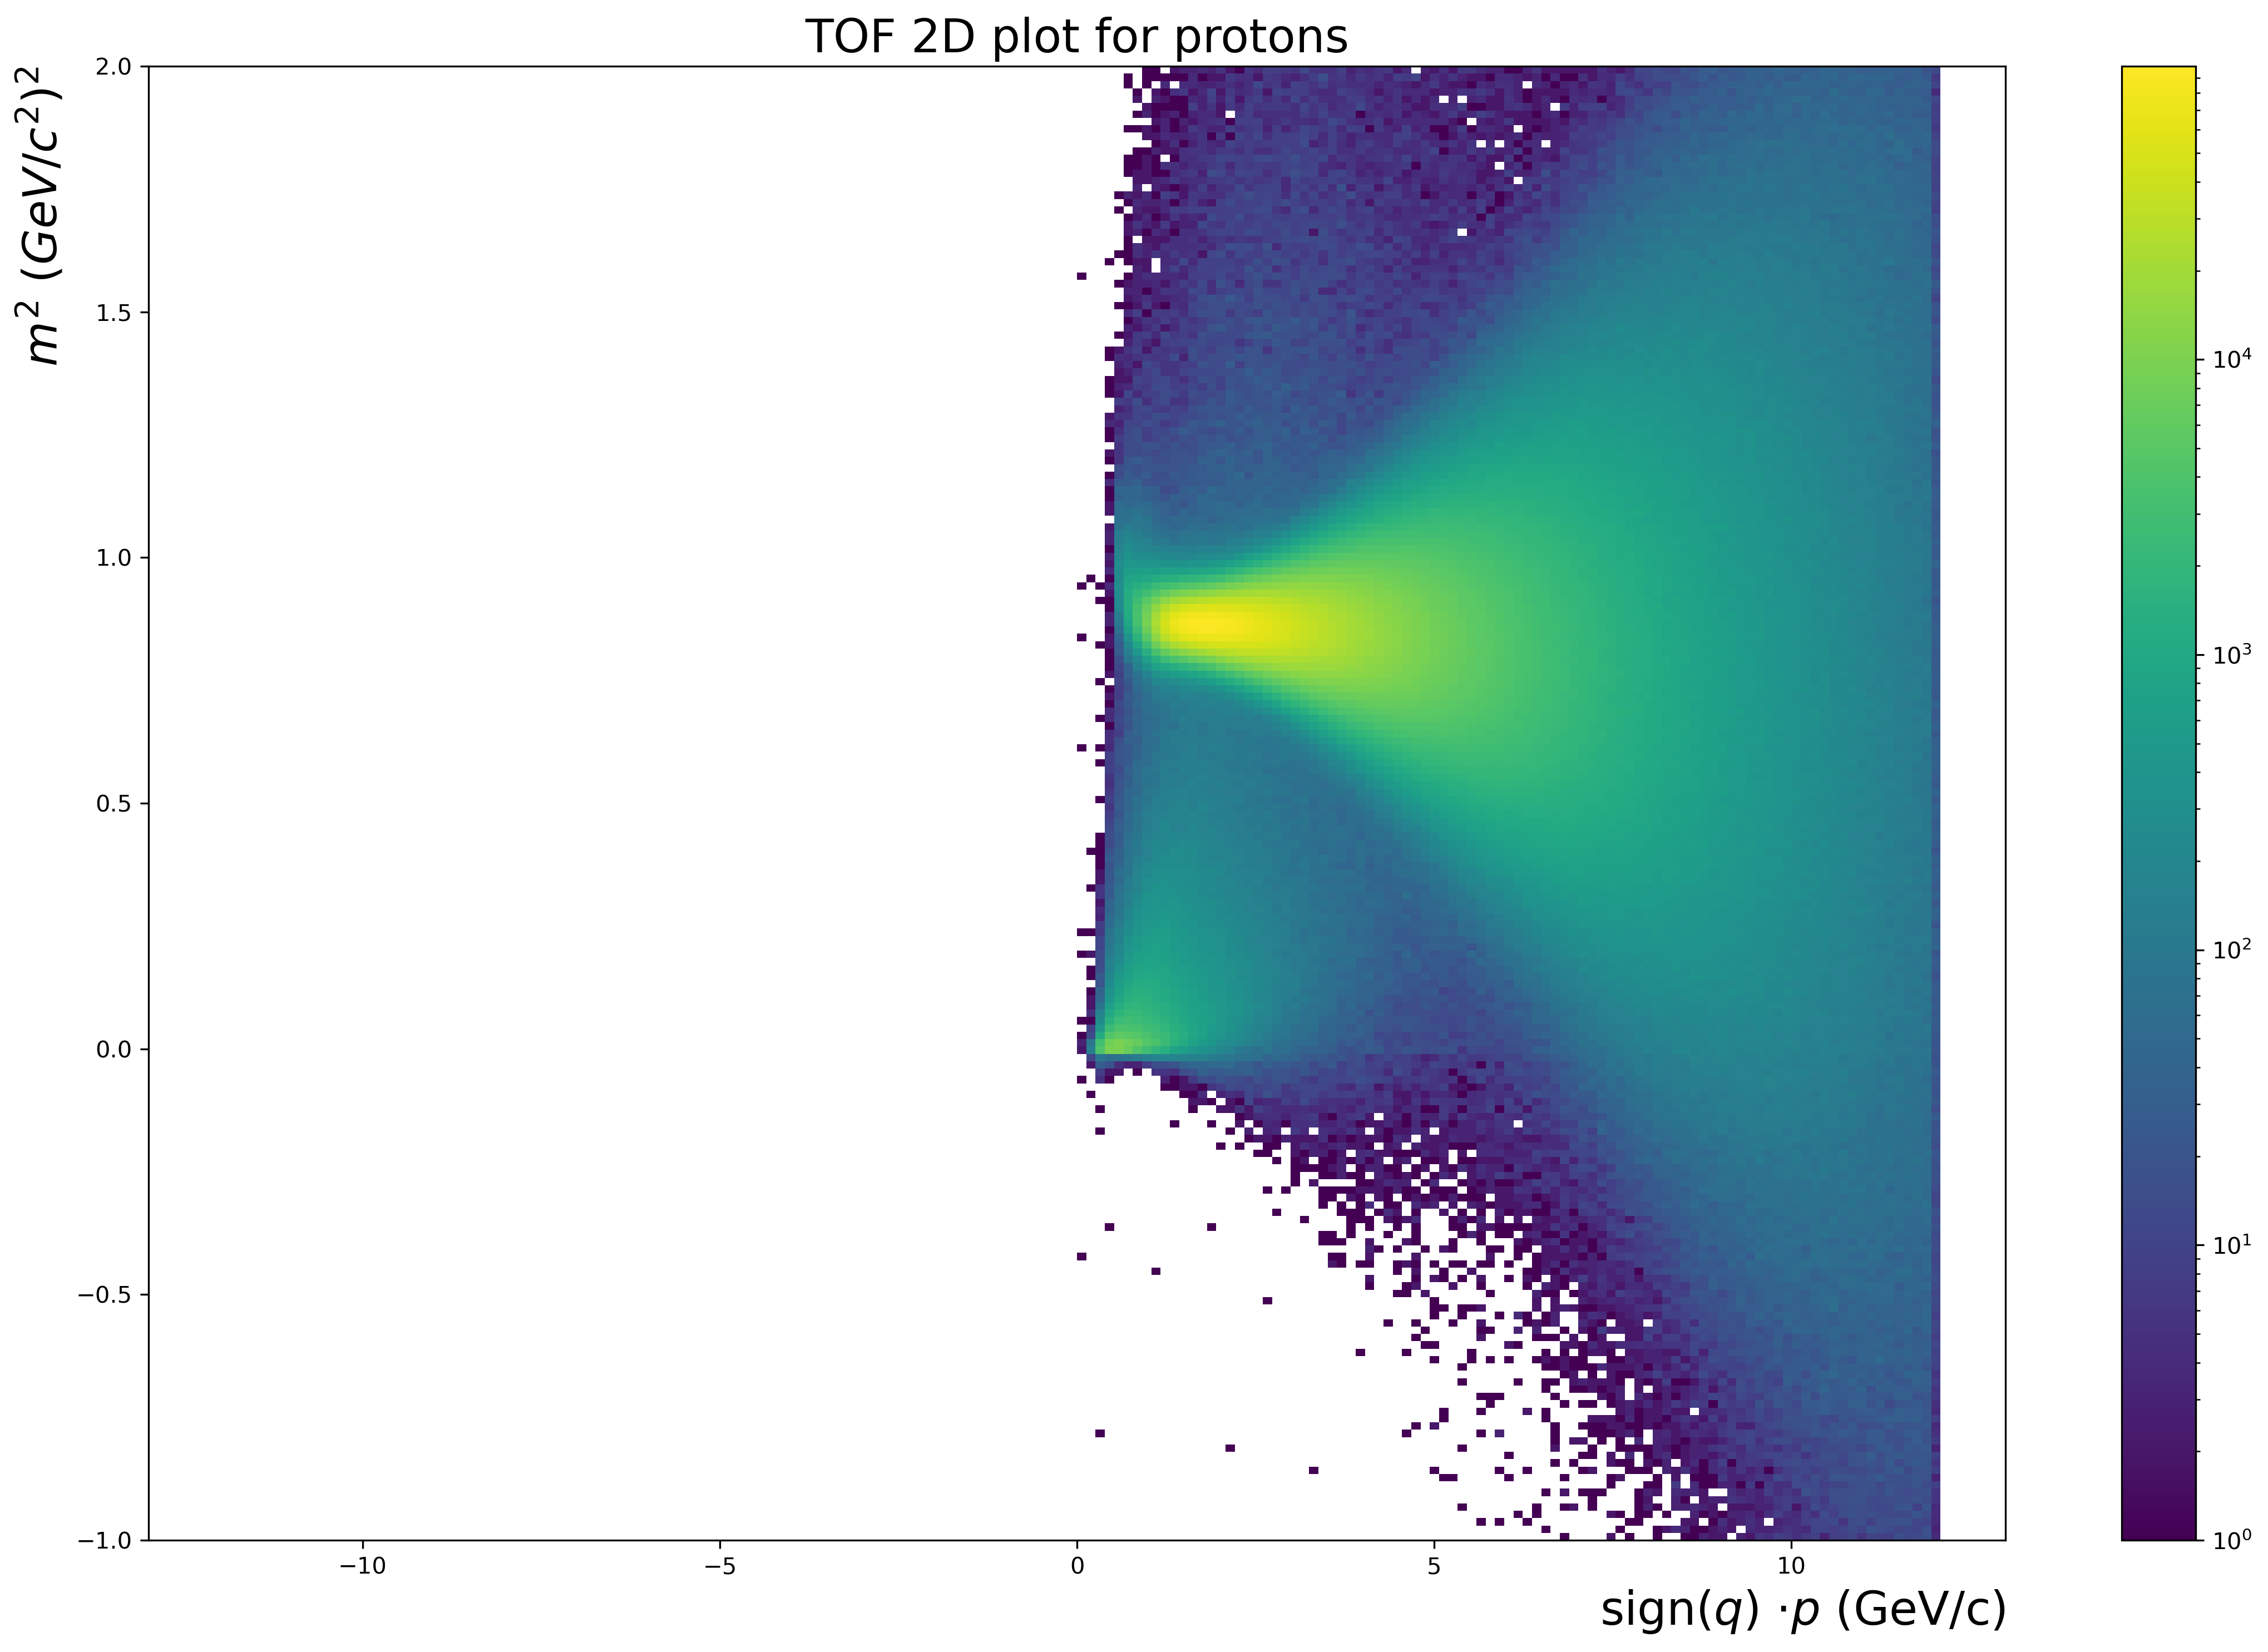

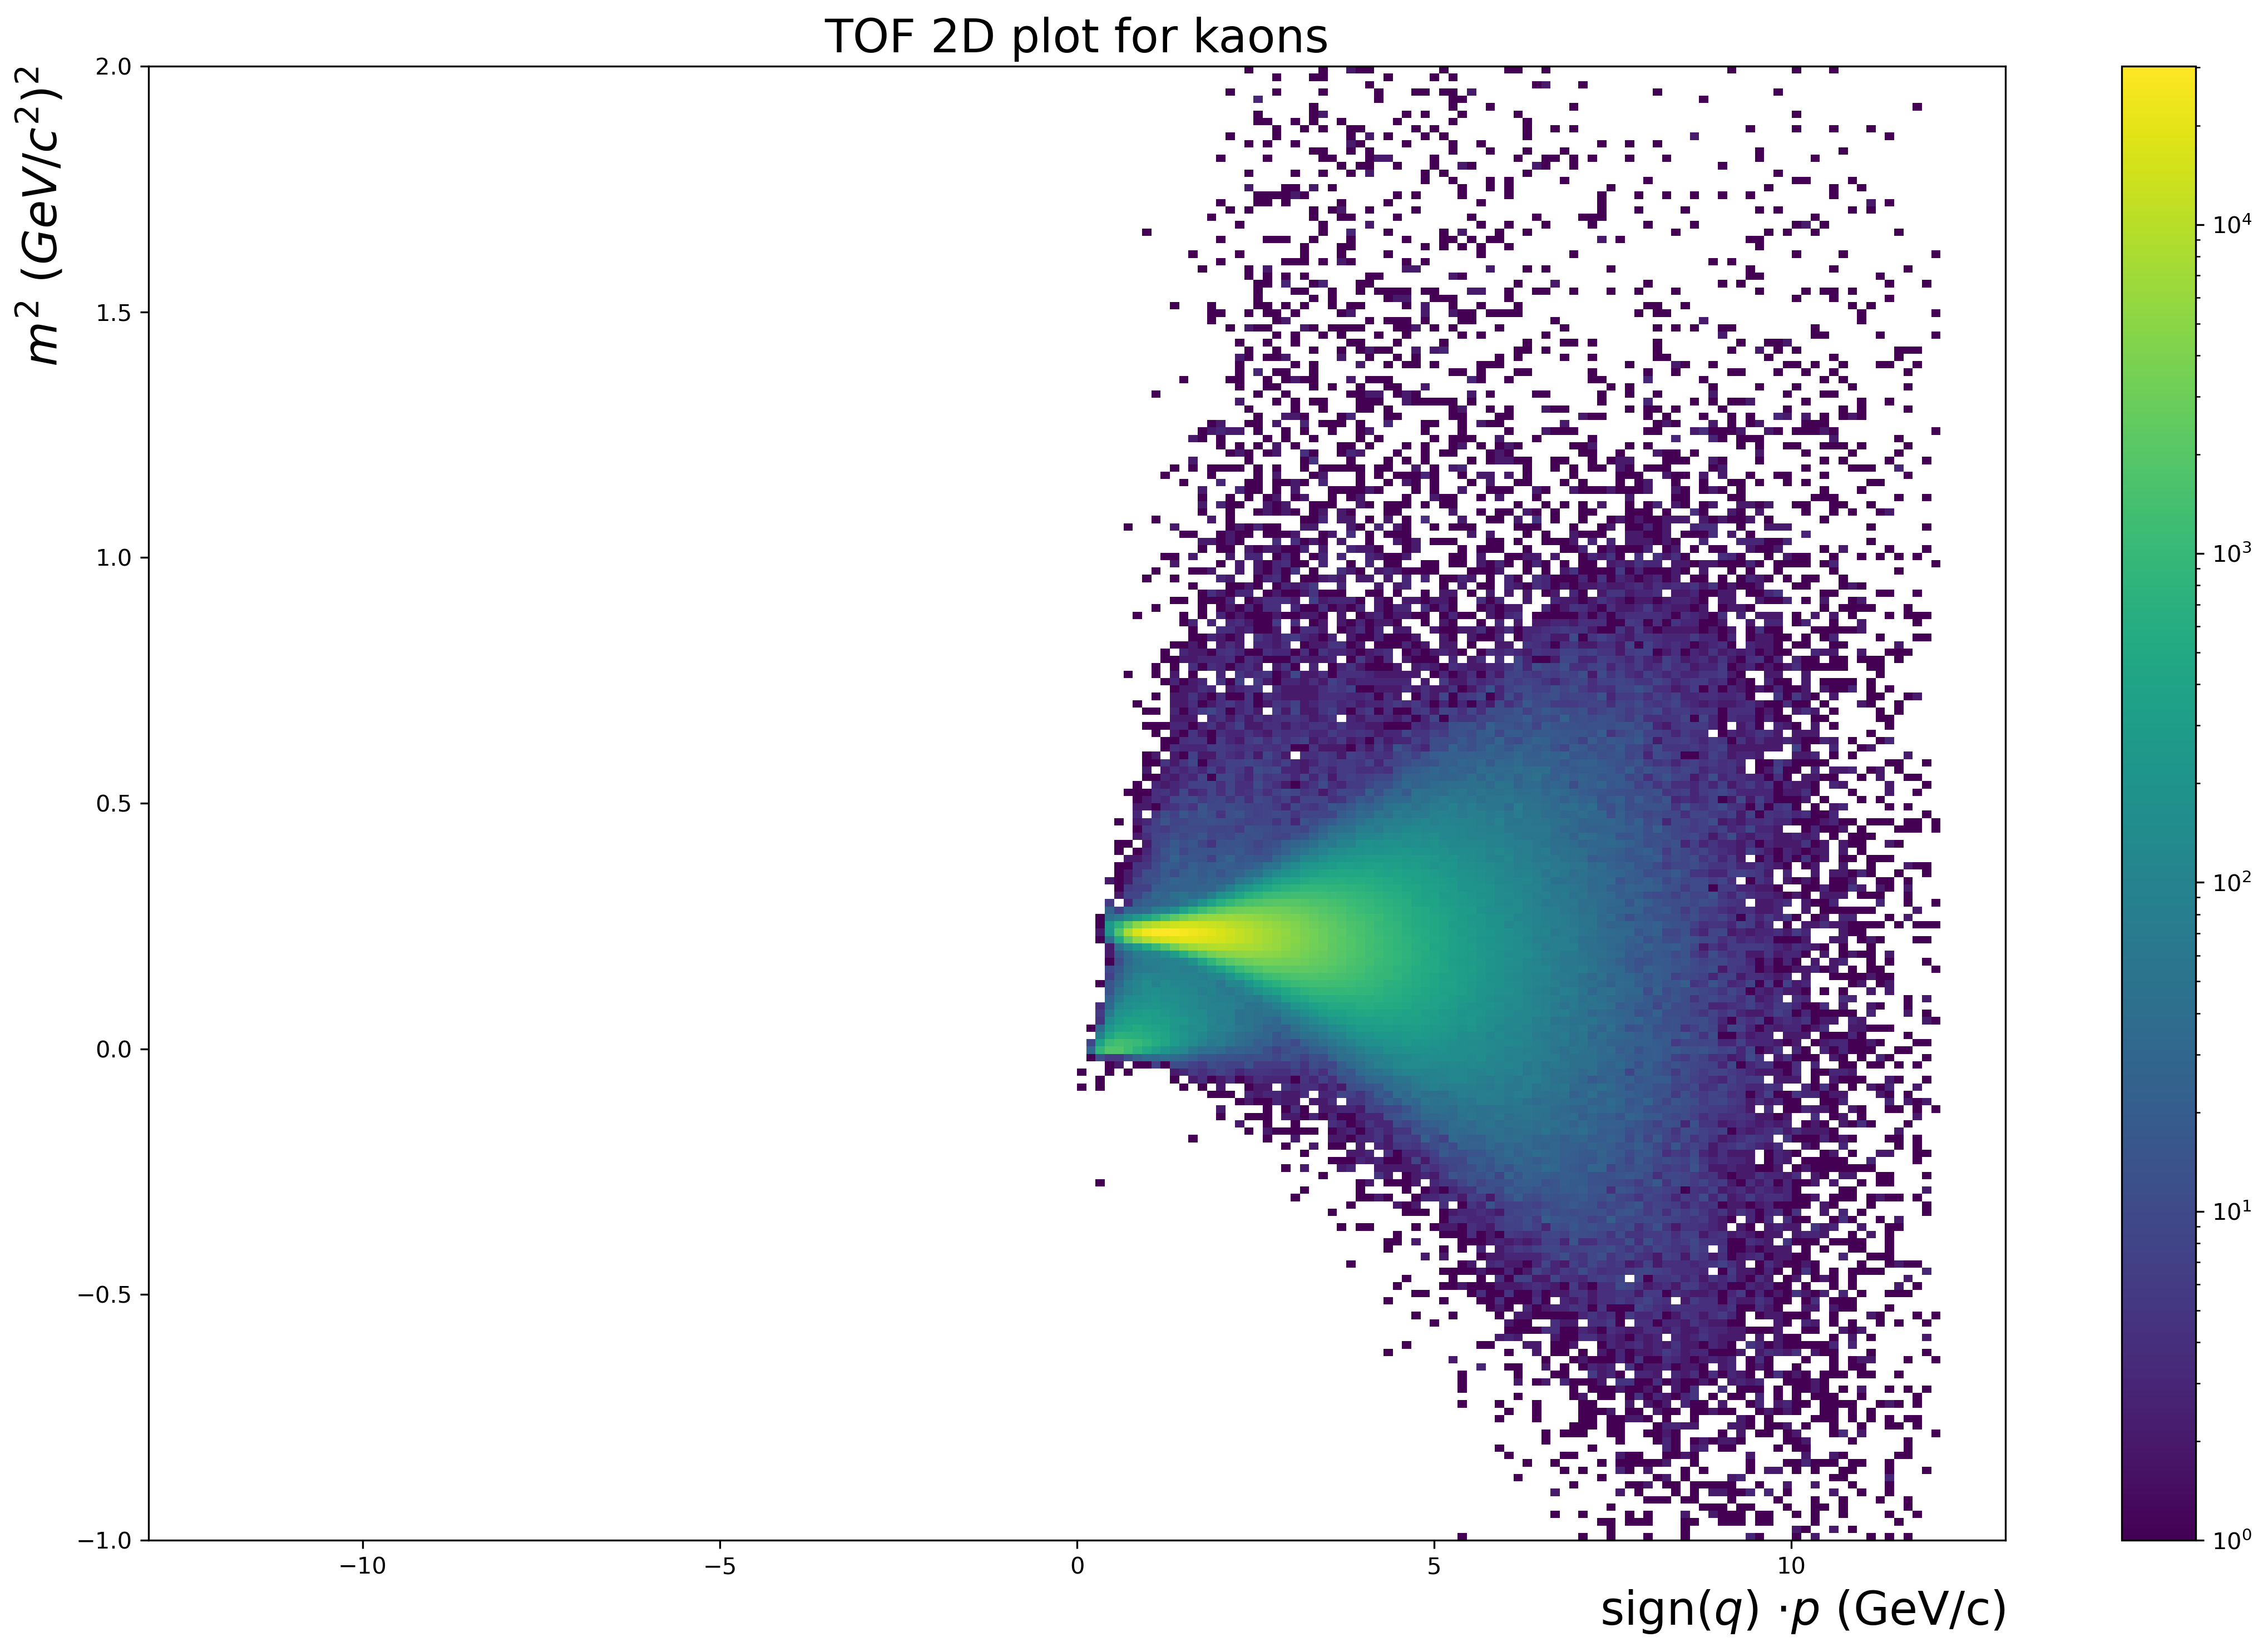

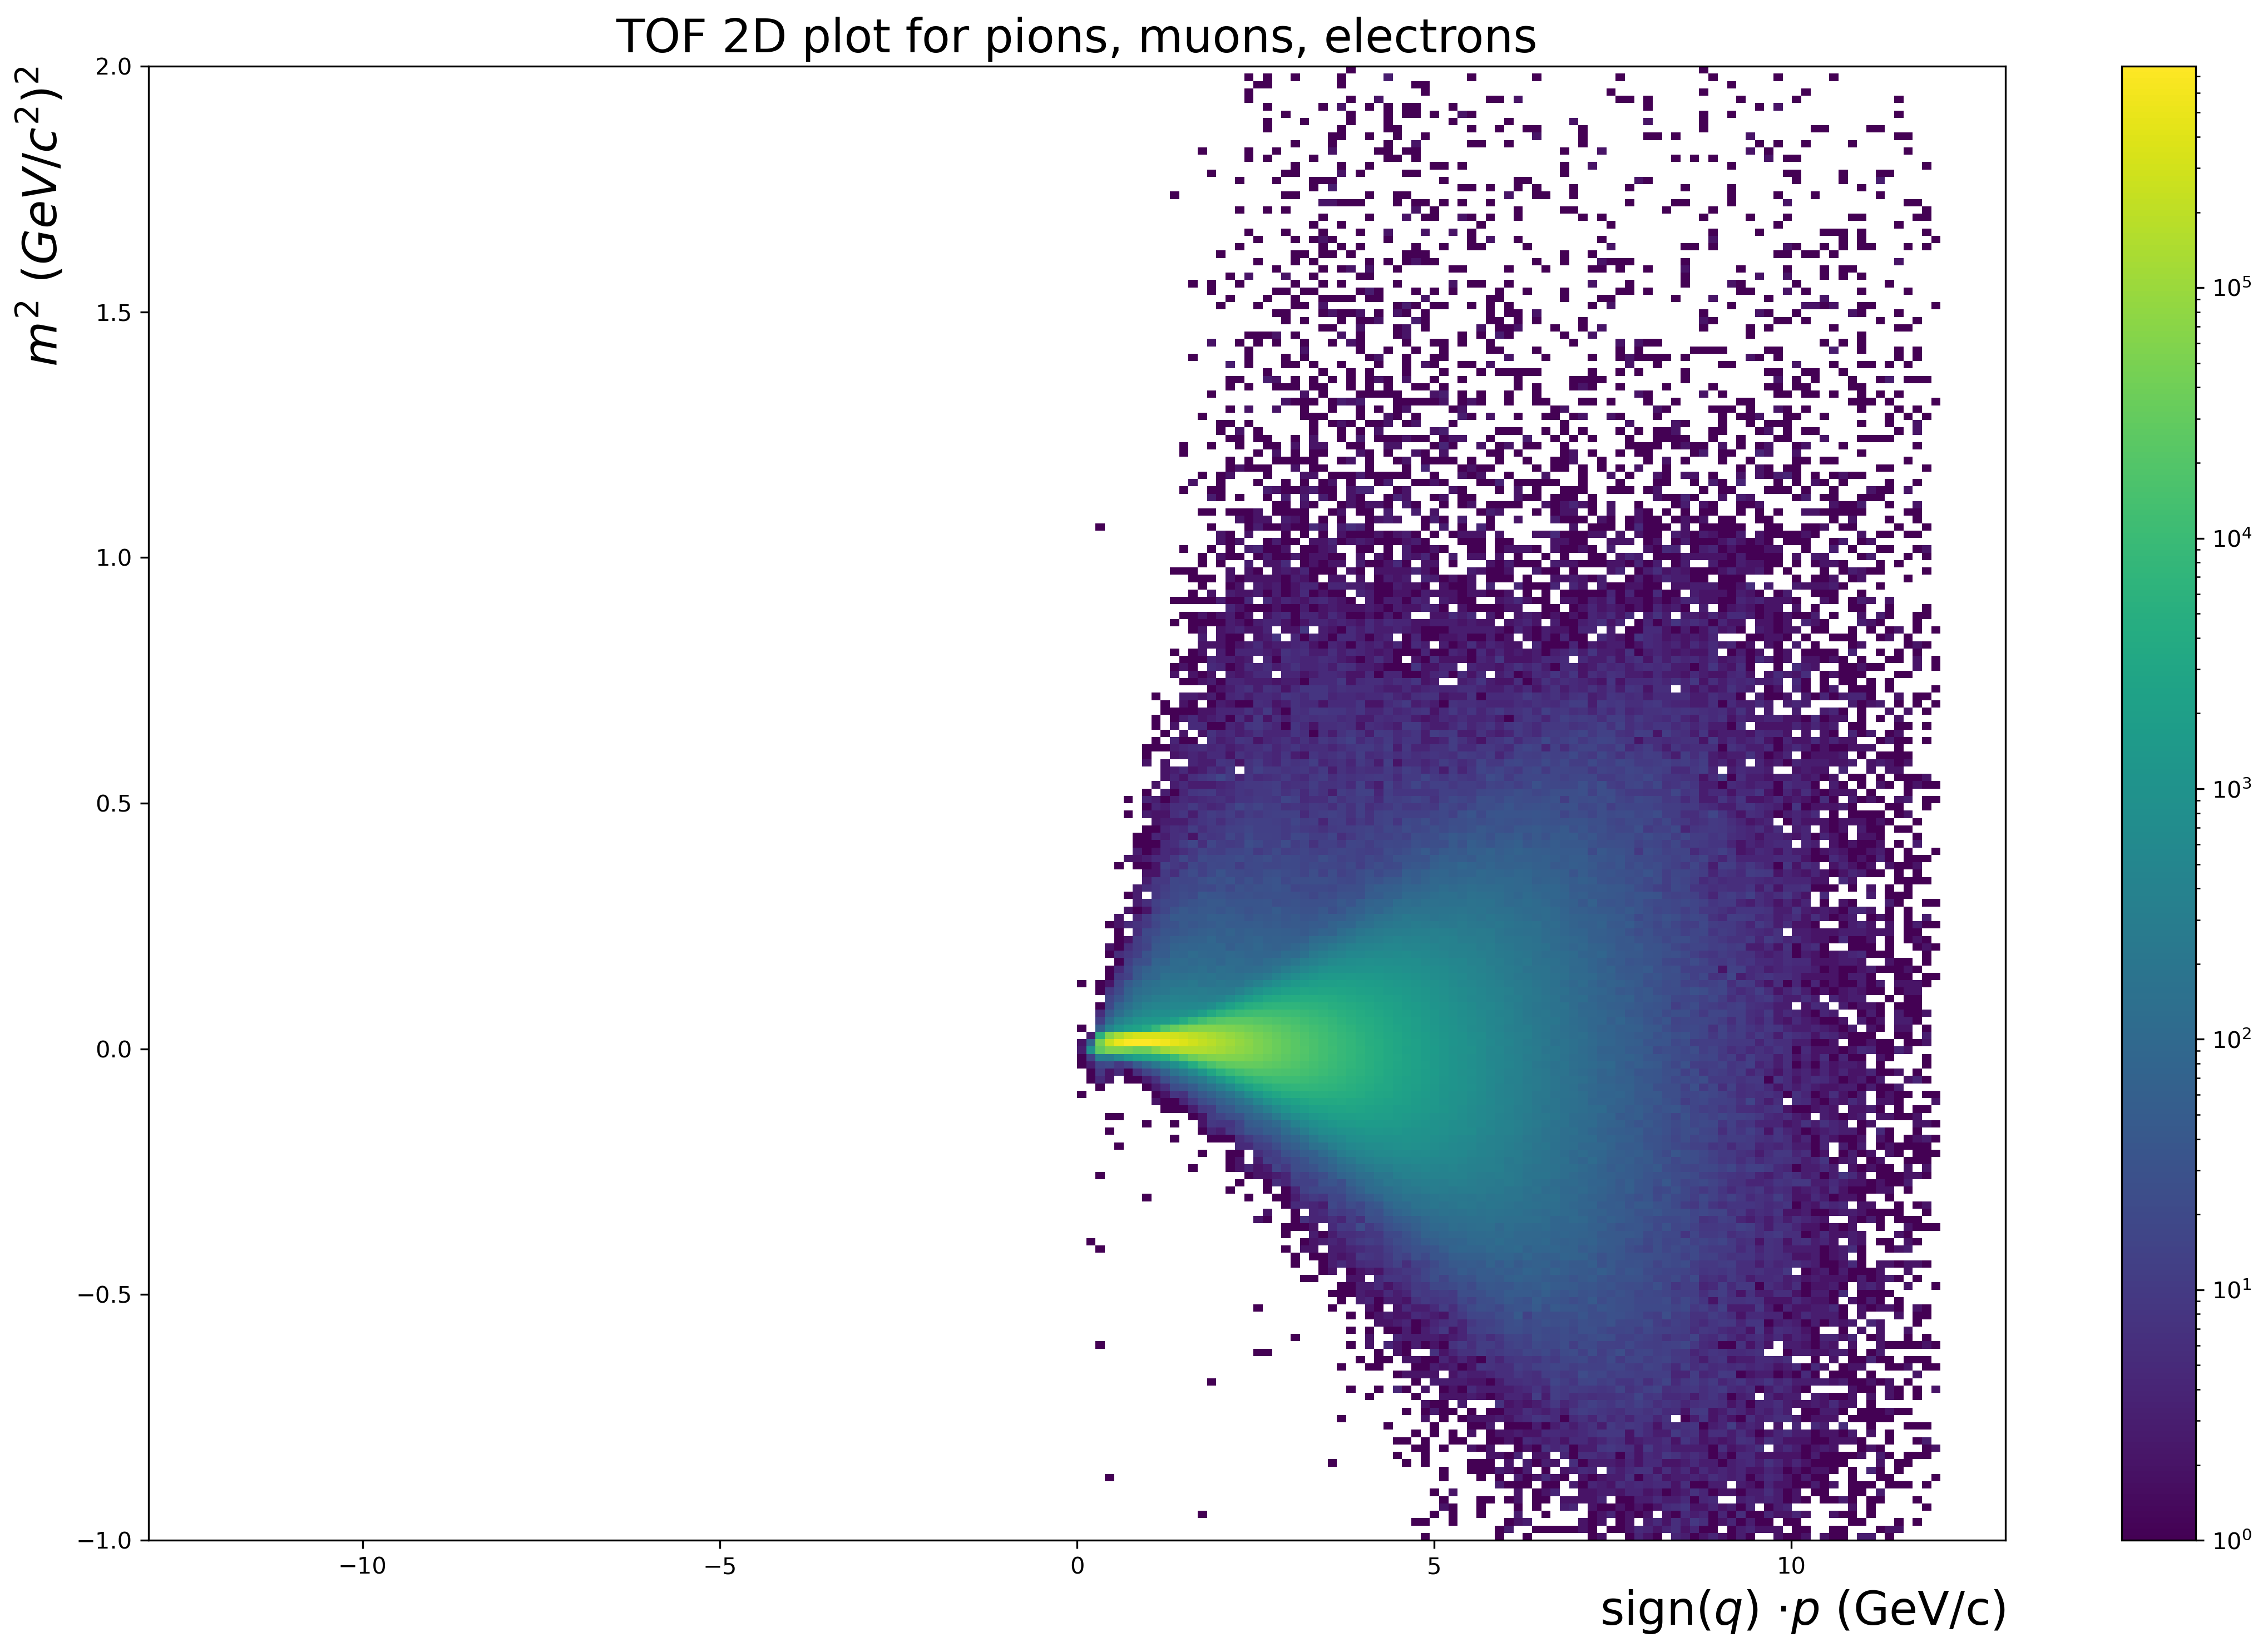

: 

In [4]:
plotting_tools.tof_plot(protons, json_file_name, "protons", save_fig=False)
plotting_tools.tof_plot(kaons, json_file_name, "kaons", save_fig=False)
plotting_tools.tof_plot(
    pions, json_file_name, "pions, muons, electrons", save_fig=False
)

In [4]:
# loading model handler
model_hdl = PrepareModel(json_file_name, optimize_hyper_params, False)
train_test_data = model_hdl.prepare_train_test_data(protons, kaons, pions)
features_for_train = model_hdl.load_features_for_train(json_file_name)
print("\nPreparing model handler\n")
model_hdl, study = model_hdl.prepare_model_handler(train_test_data=train_test_data)
# train model
train = TrainModel(model_hdl, model_name)
sample_weights = compute_sample_weight(
    class_weight="balanced", y=train_test_data[1]  # labels of training dataset
)
train.train_model_handler(train_test_data, sample_weights)
print("\nModel trained!")


Preparing model handler


ModelHandler ready using configuration from config.json
Training xgboost model for classification
Number of detected classes: 3
Training the model: ...
Training the model: Done!
Testing the model: ...
ROC_AUC_score: 0.847017
Testing the model: Done!

Model trained!


Creating shap plots...


AssertionError: Feature and SHAP matrices must have the same number of rows!

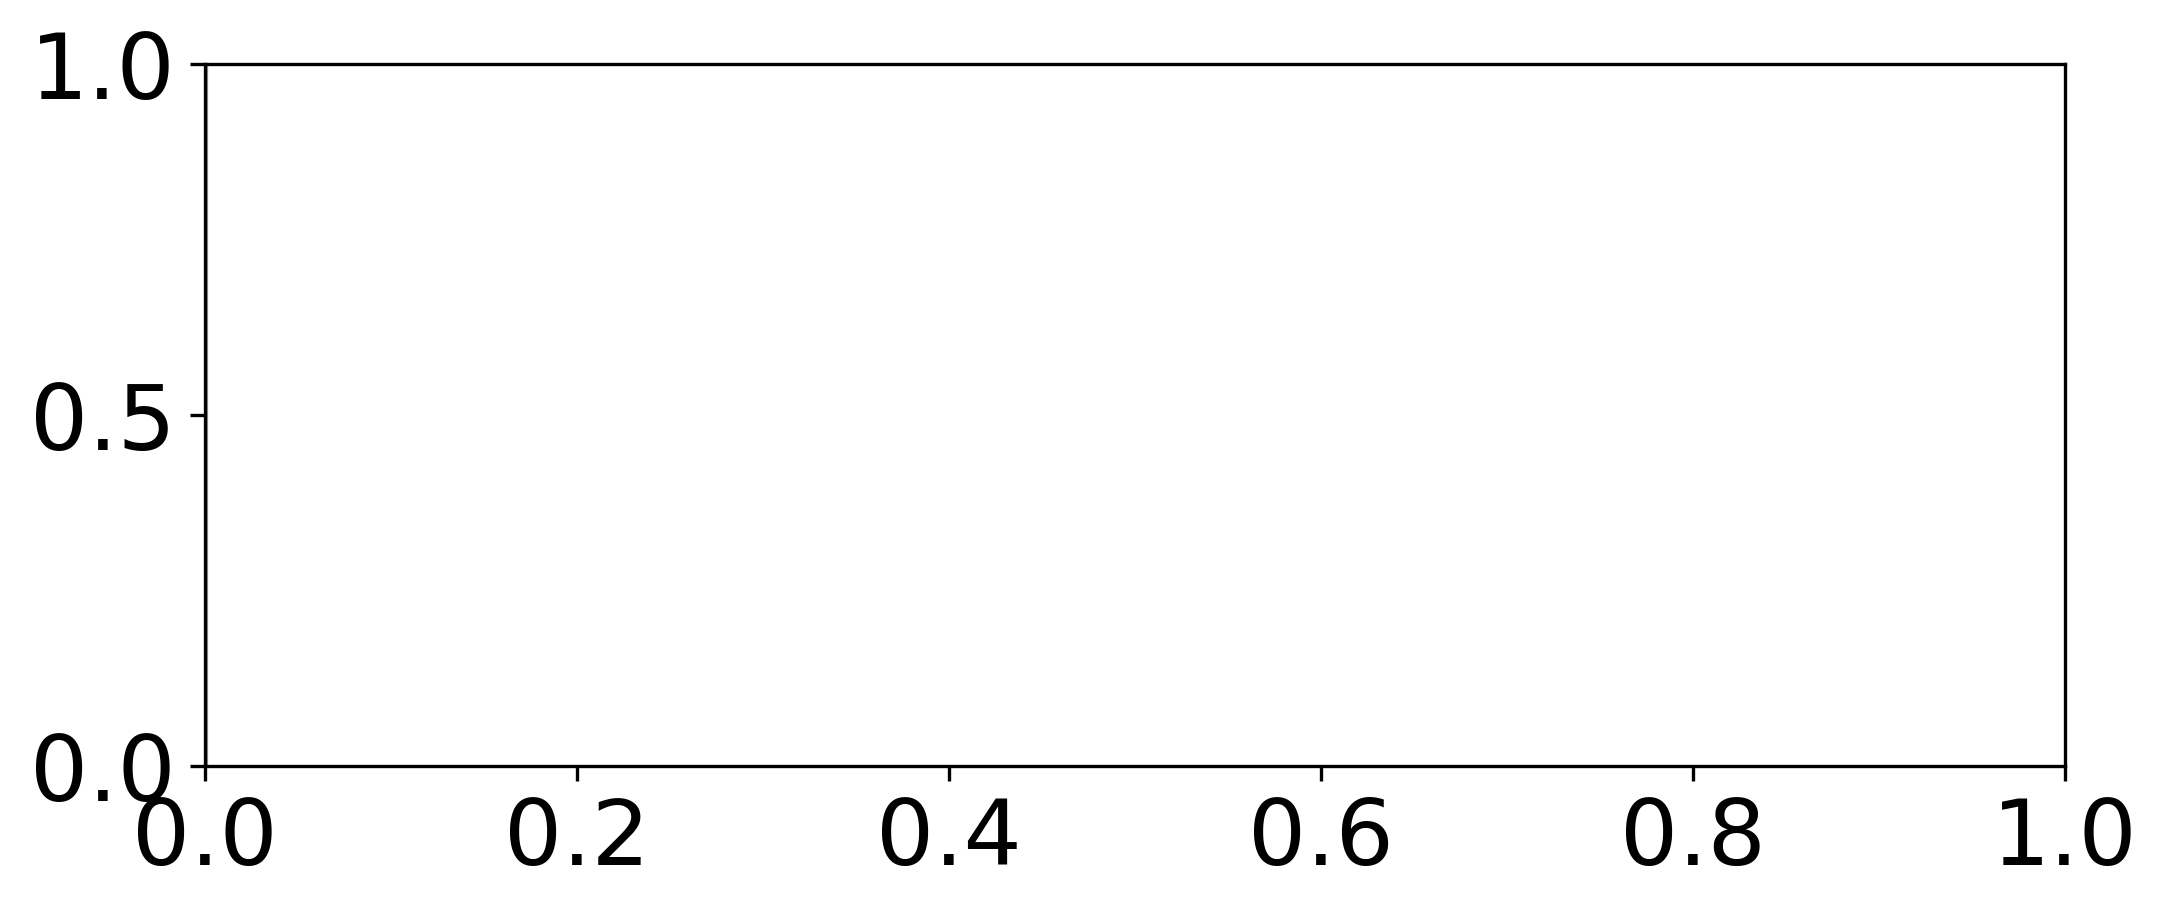

: 

In [5]:
feature_names = [item.replace("Complex_", "") for item in features_for_train]
plotting_tools.plot_shap_summary(
    train_test_data[2][features_for_train],
    train_test_data[3],
    model_hdl,
    features_for_train,
    10
)


In [31]:
train_test_data[0][train_test_data[0].isna().any(axis=1)].columns

Index(['Complex_axis_a_rich', 'Complex_axis_b_rich',
       'Complex_chi2_ov_ndf_rich', 'Complex_chi2_vtx', 'Complex_eta',
       'Complex_id', 'Complex_mass', 'Complex_mass2', 'Complex_n_hits_rich',
       'Complex_nhits_trd', 'Complex_p', 'Complex_pT', 'Complex_phi',
       'Complex_phi_ellipse_rich', 'Complex_phi_rich', 'Complex_pid',
       'Complex_px', 'Complex_py', 'Complex_pz', 'Complex_q',
       'Complex_radial_angle_rich', 'Complex_radial_pos_rich',
       'Complex_radius_rich', 'Complex_rapidity', 'Complex_trd_proba_e',
       'Complex_trd_proba_k', 'Complex_trd_proba_p', 'Complex_trd_proba_pi'],
      dtype='object')

In [4]:
y_pred_test = model_hdl.predict(train_test_data[2], False)

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


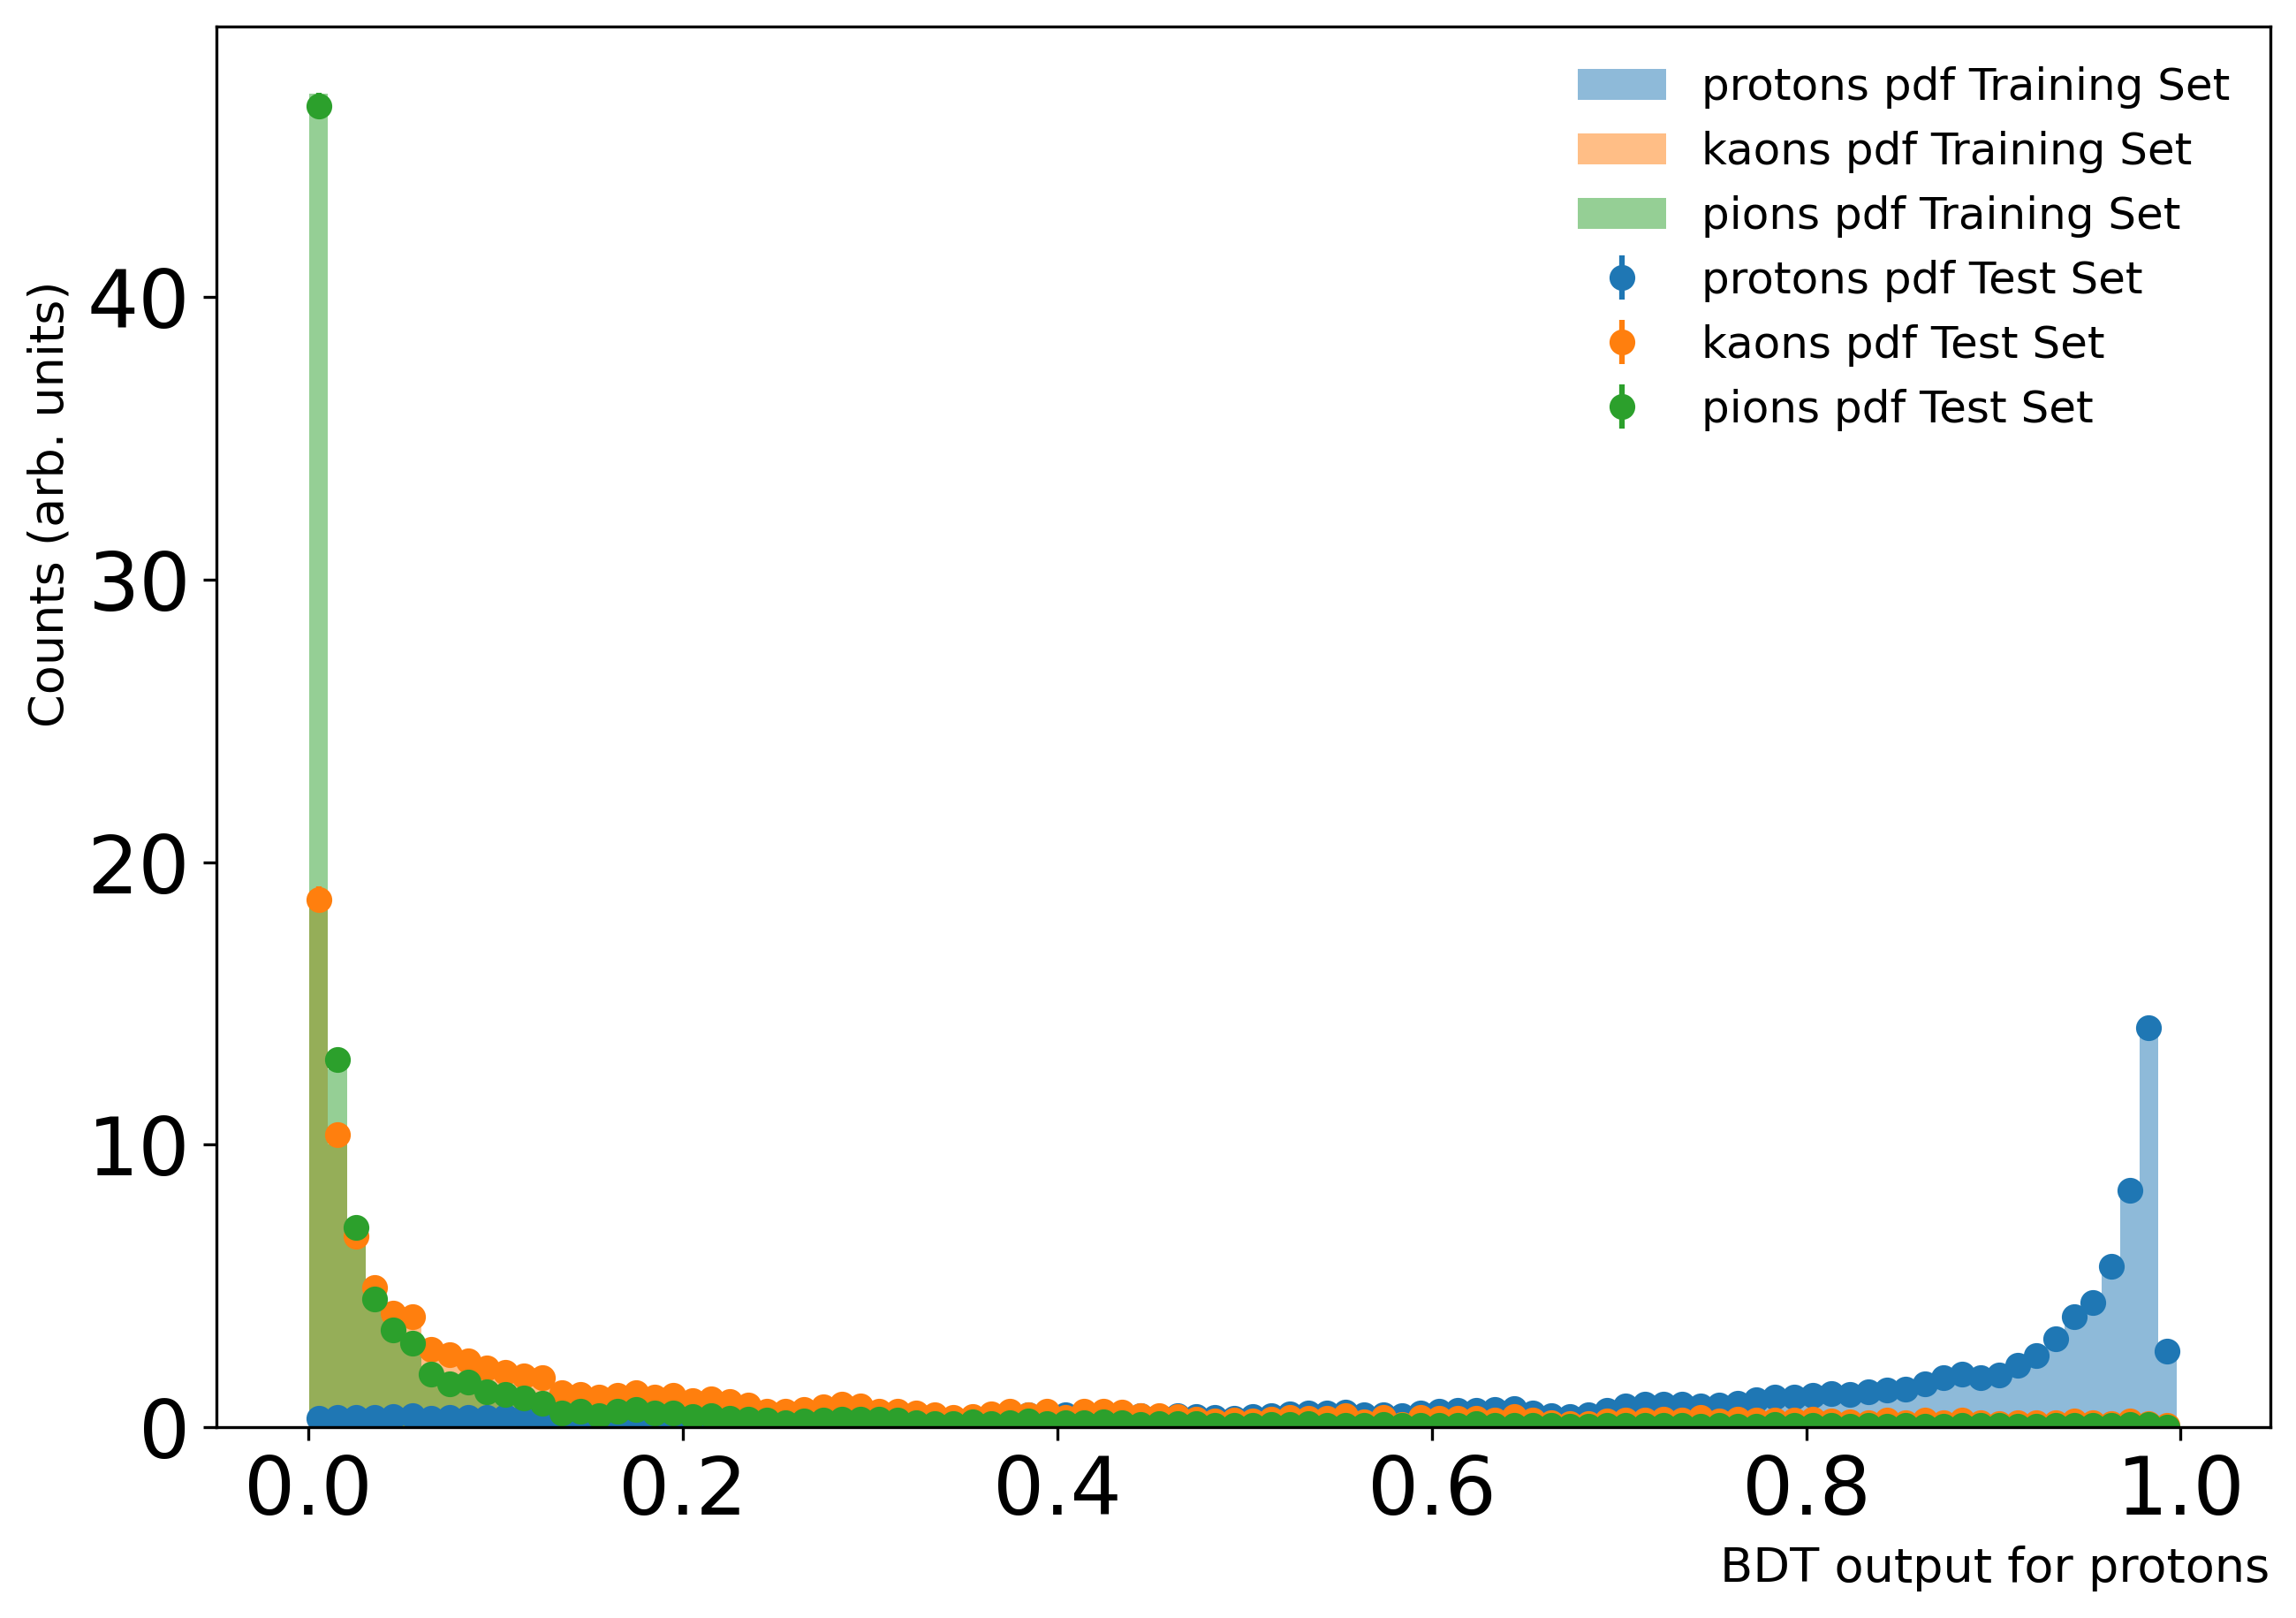

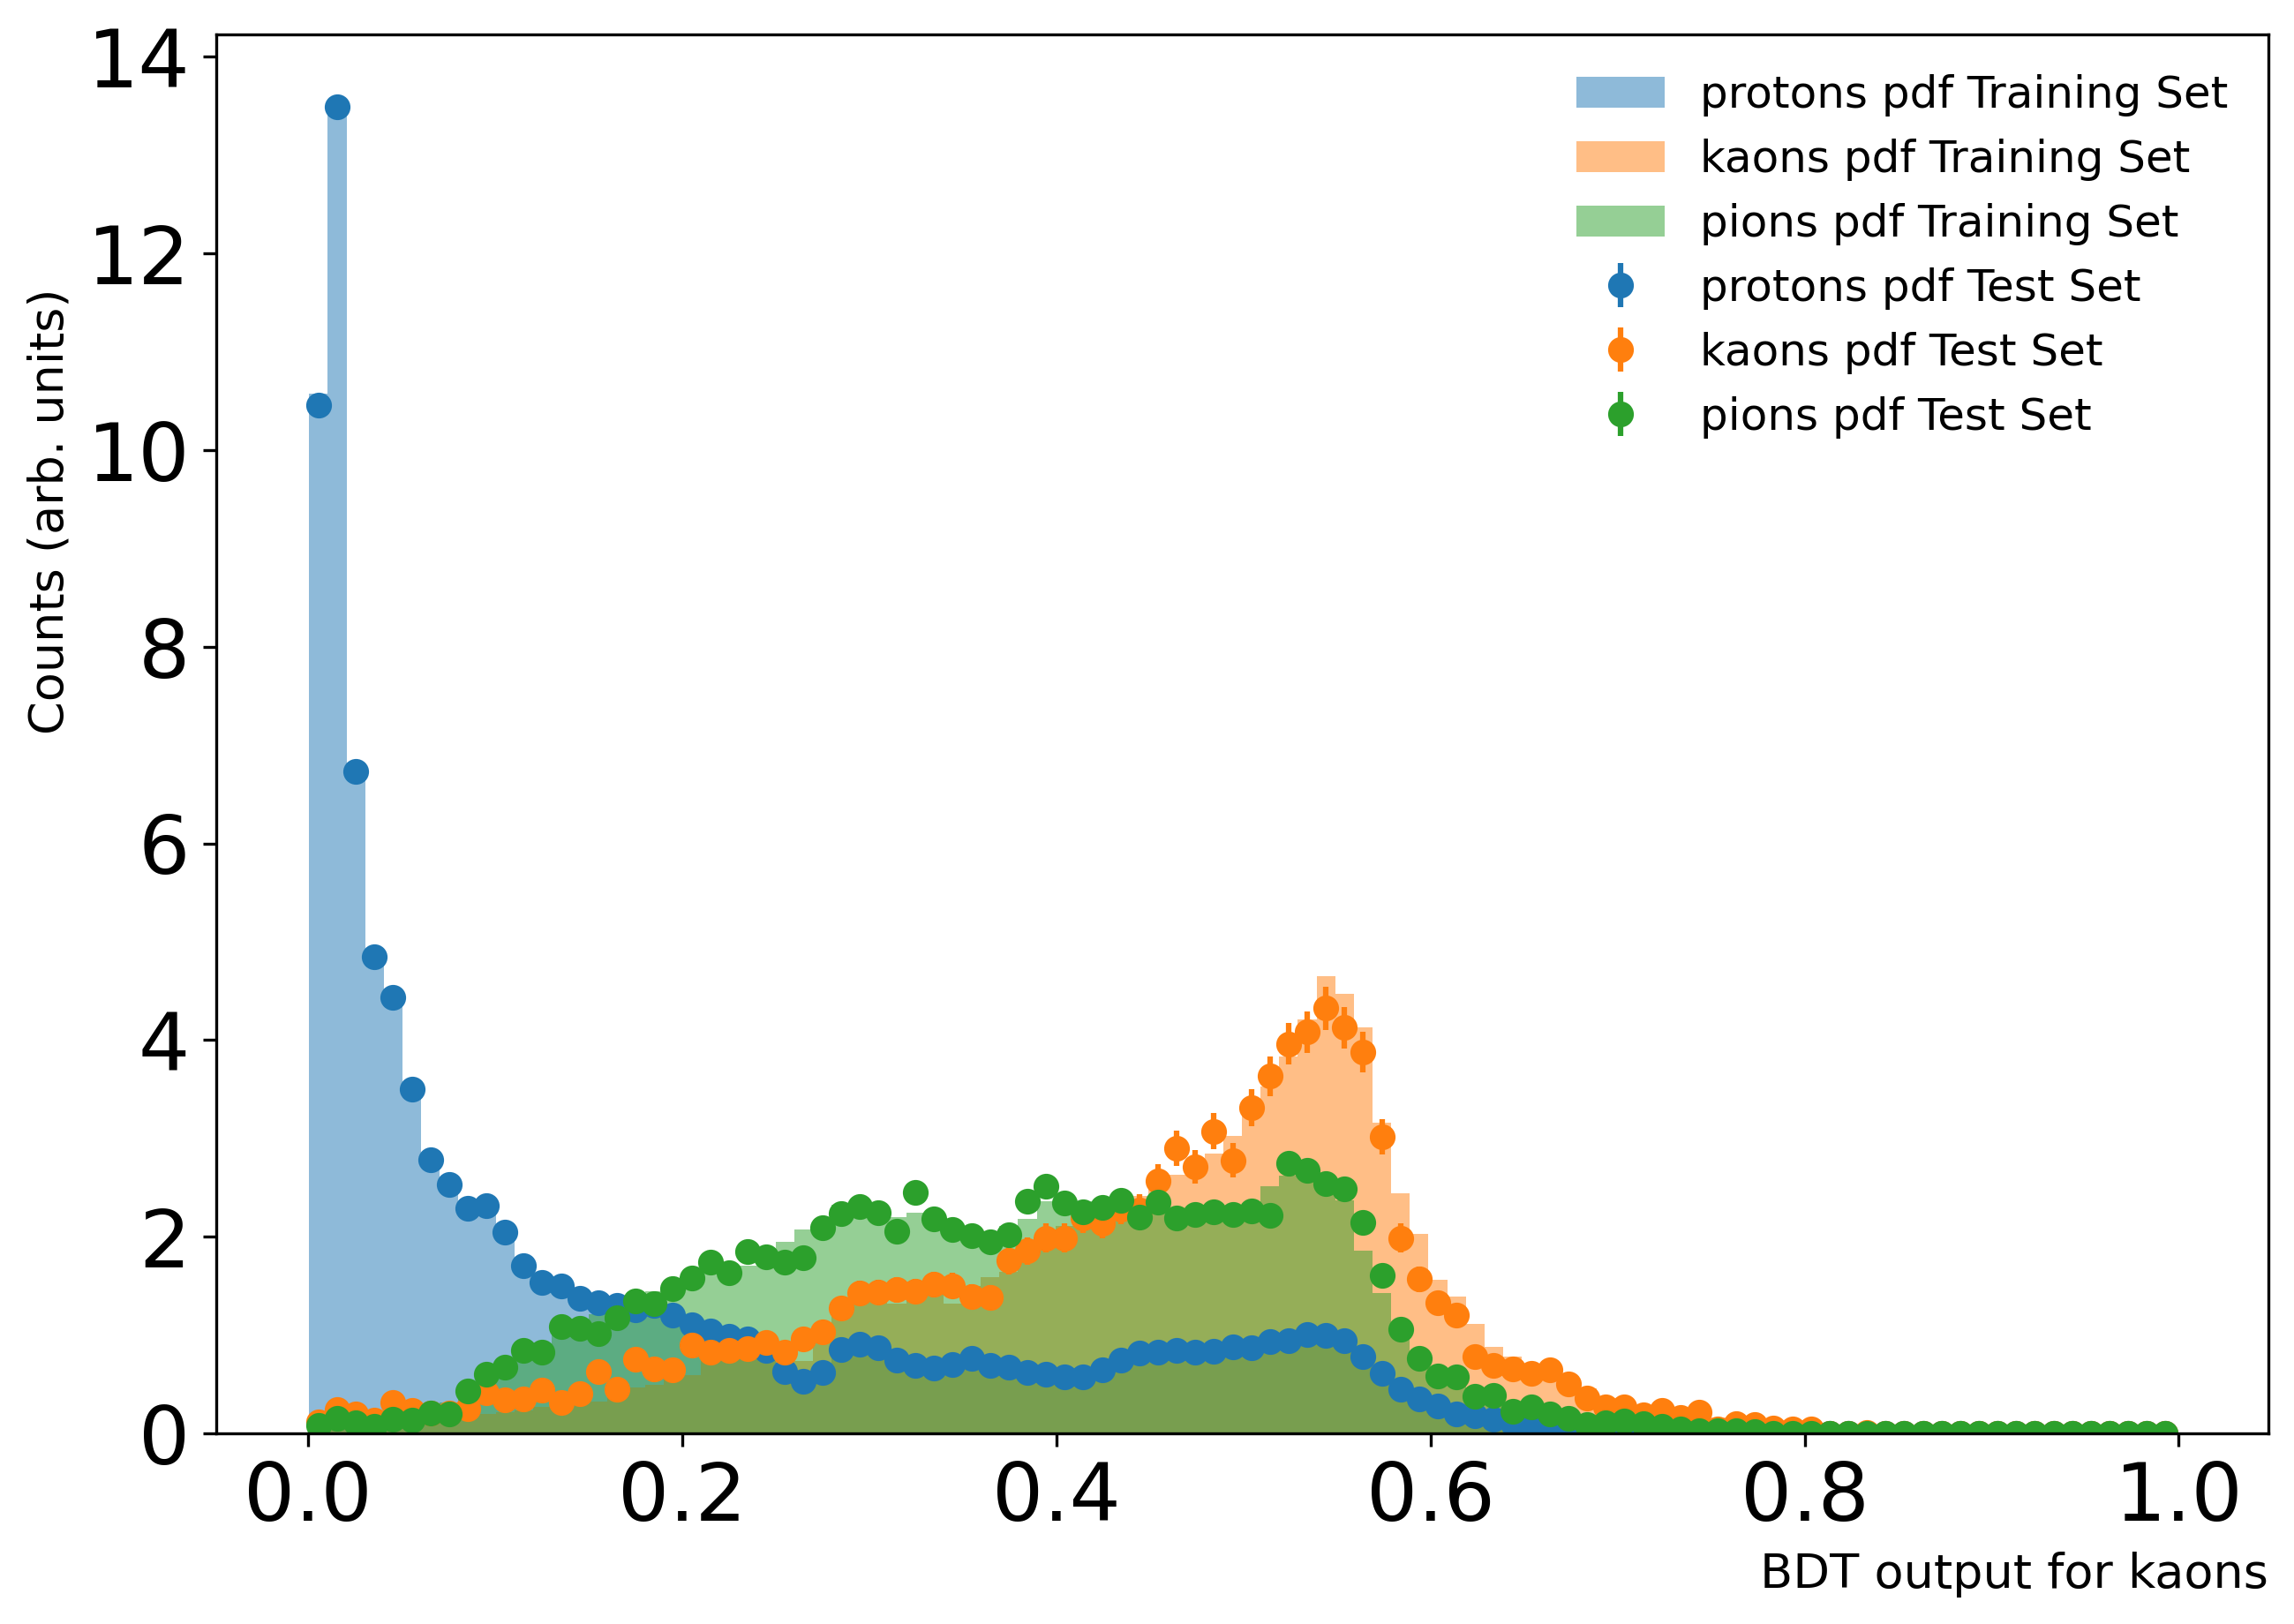

: 

In [11]:
import importlib
importlib.reload(plotting_tools)
plotting_tools.output_train_test_plot(
            train.model_hdl, train_test_data, save_fig=save_plots, logscale=False
        )

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


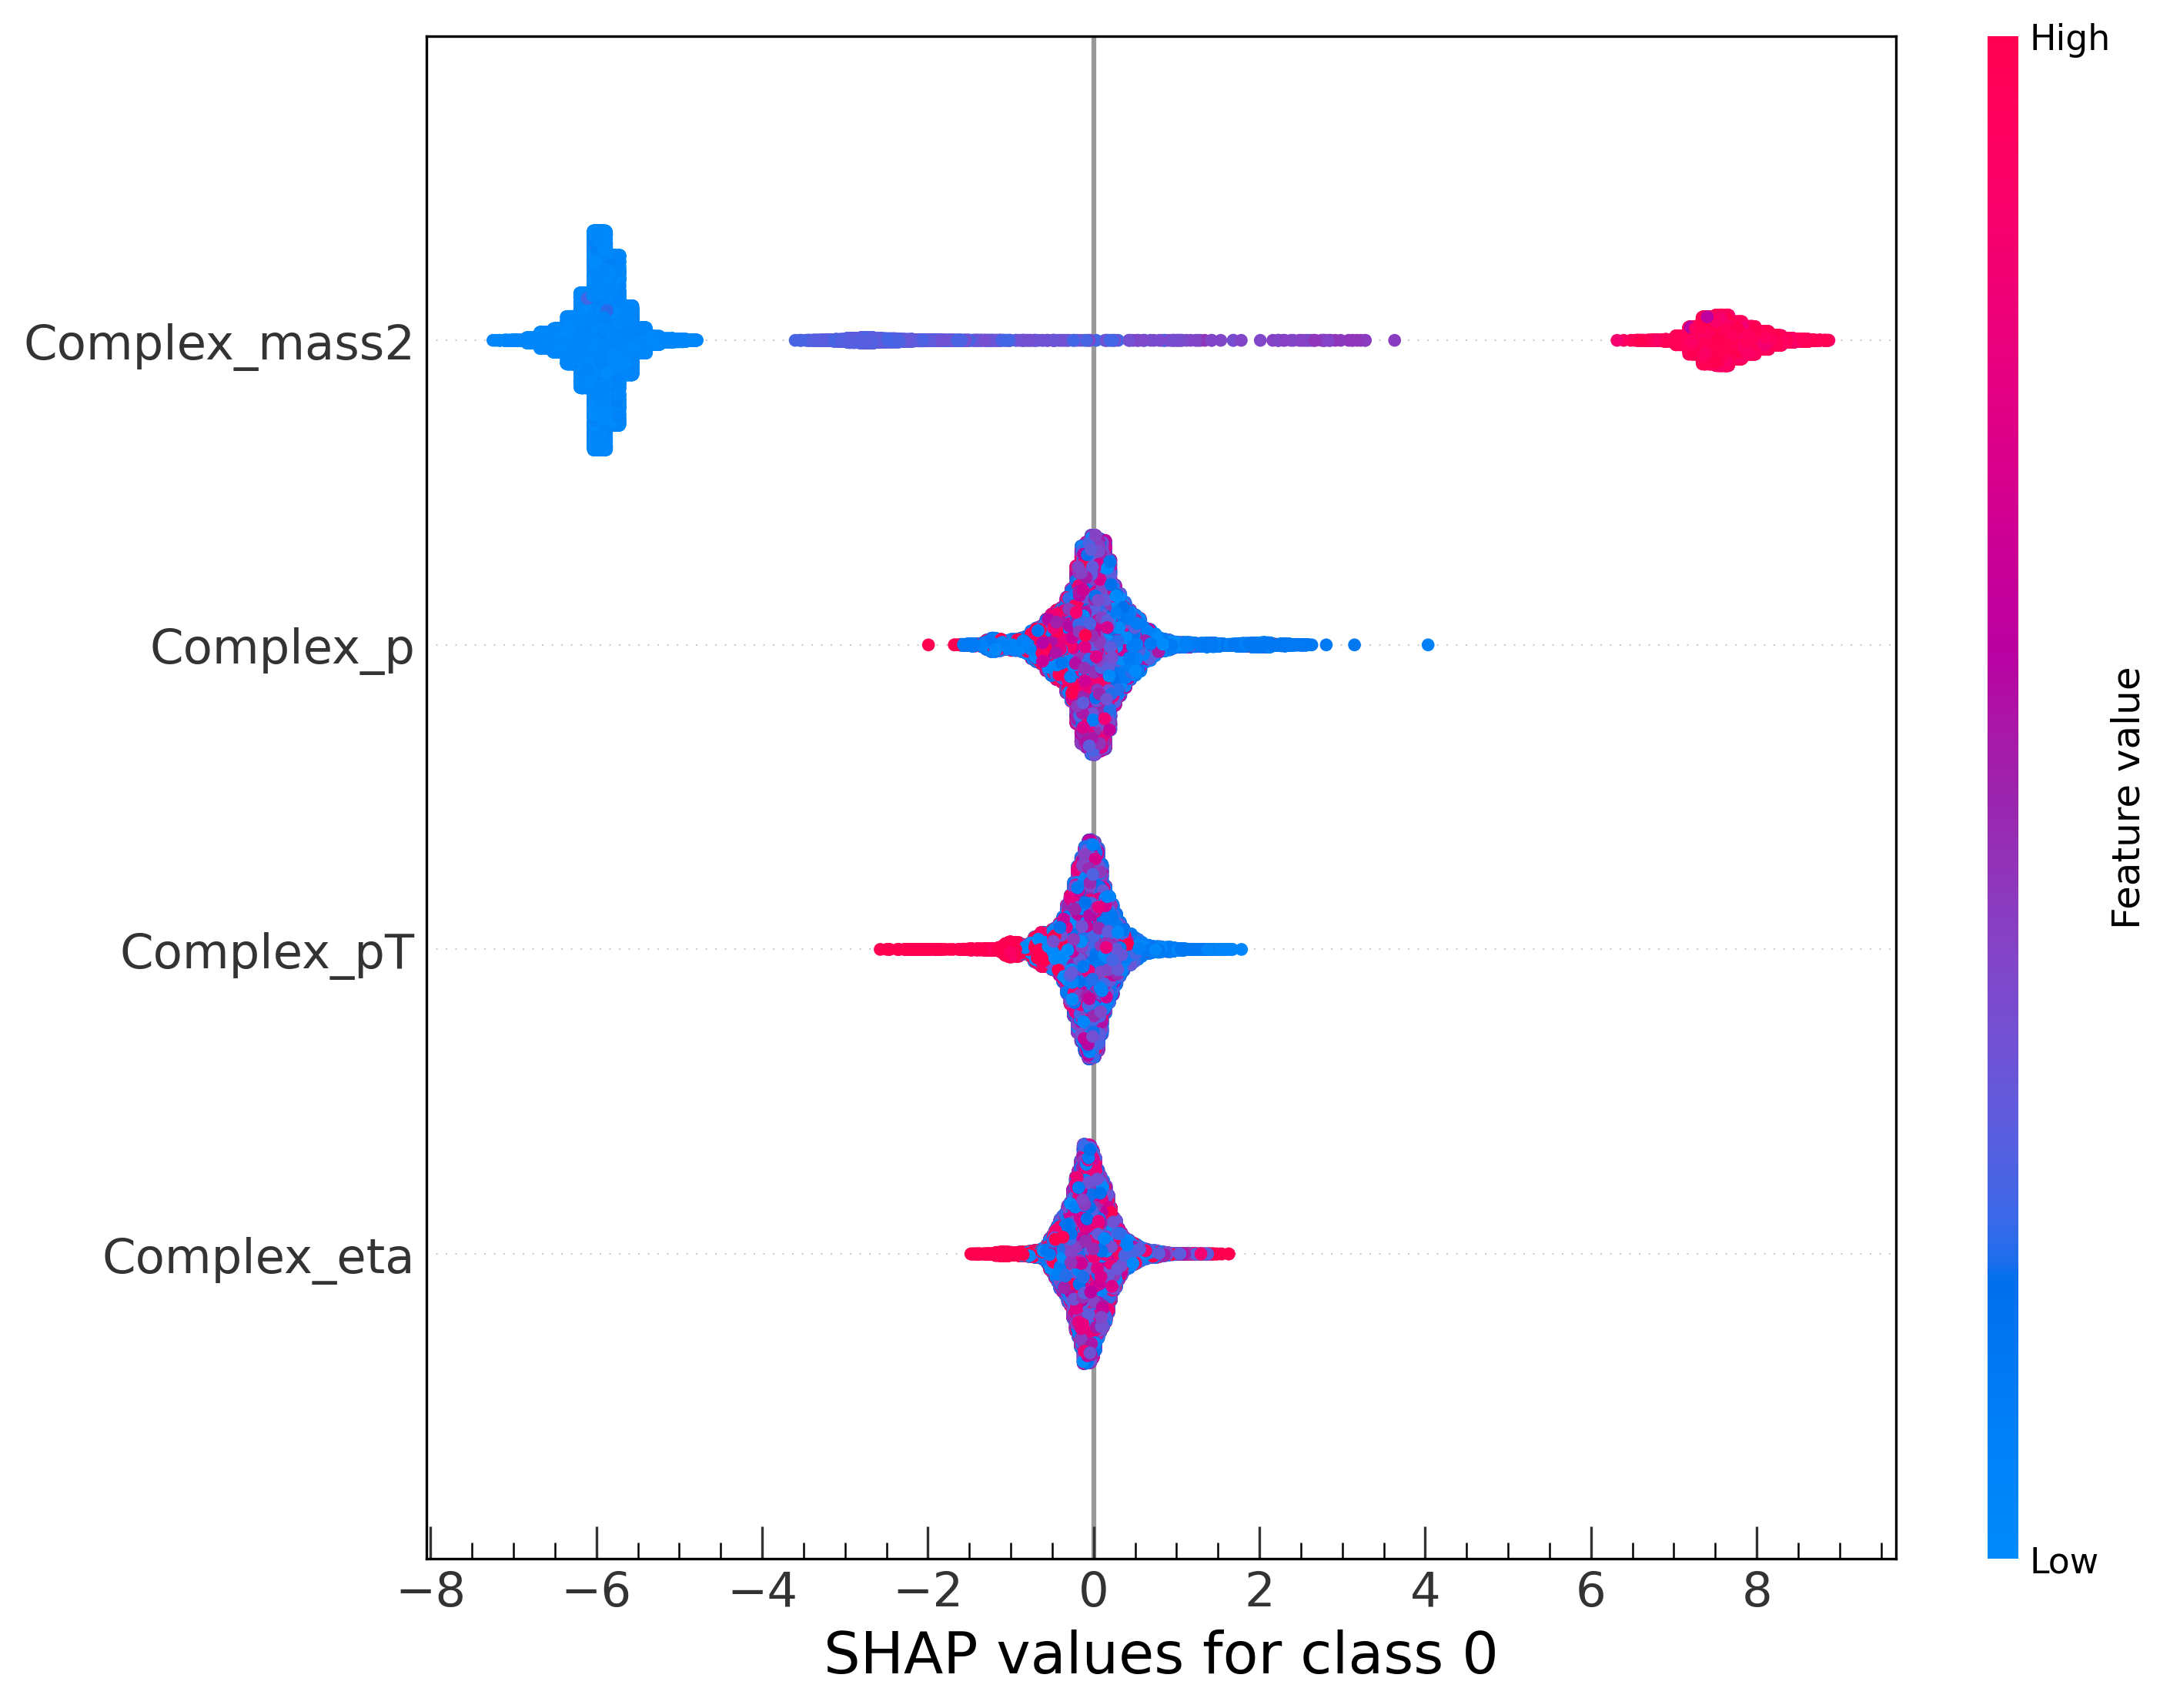

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


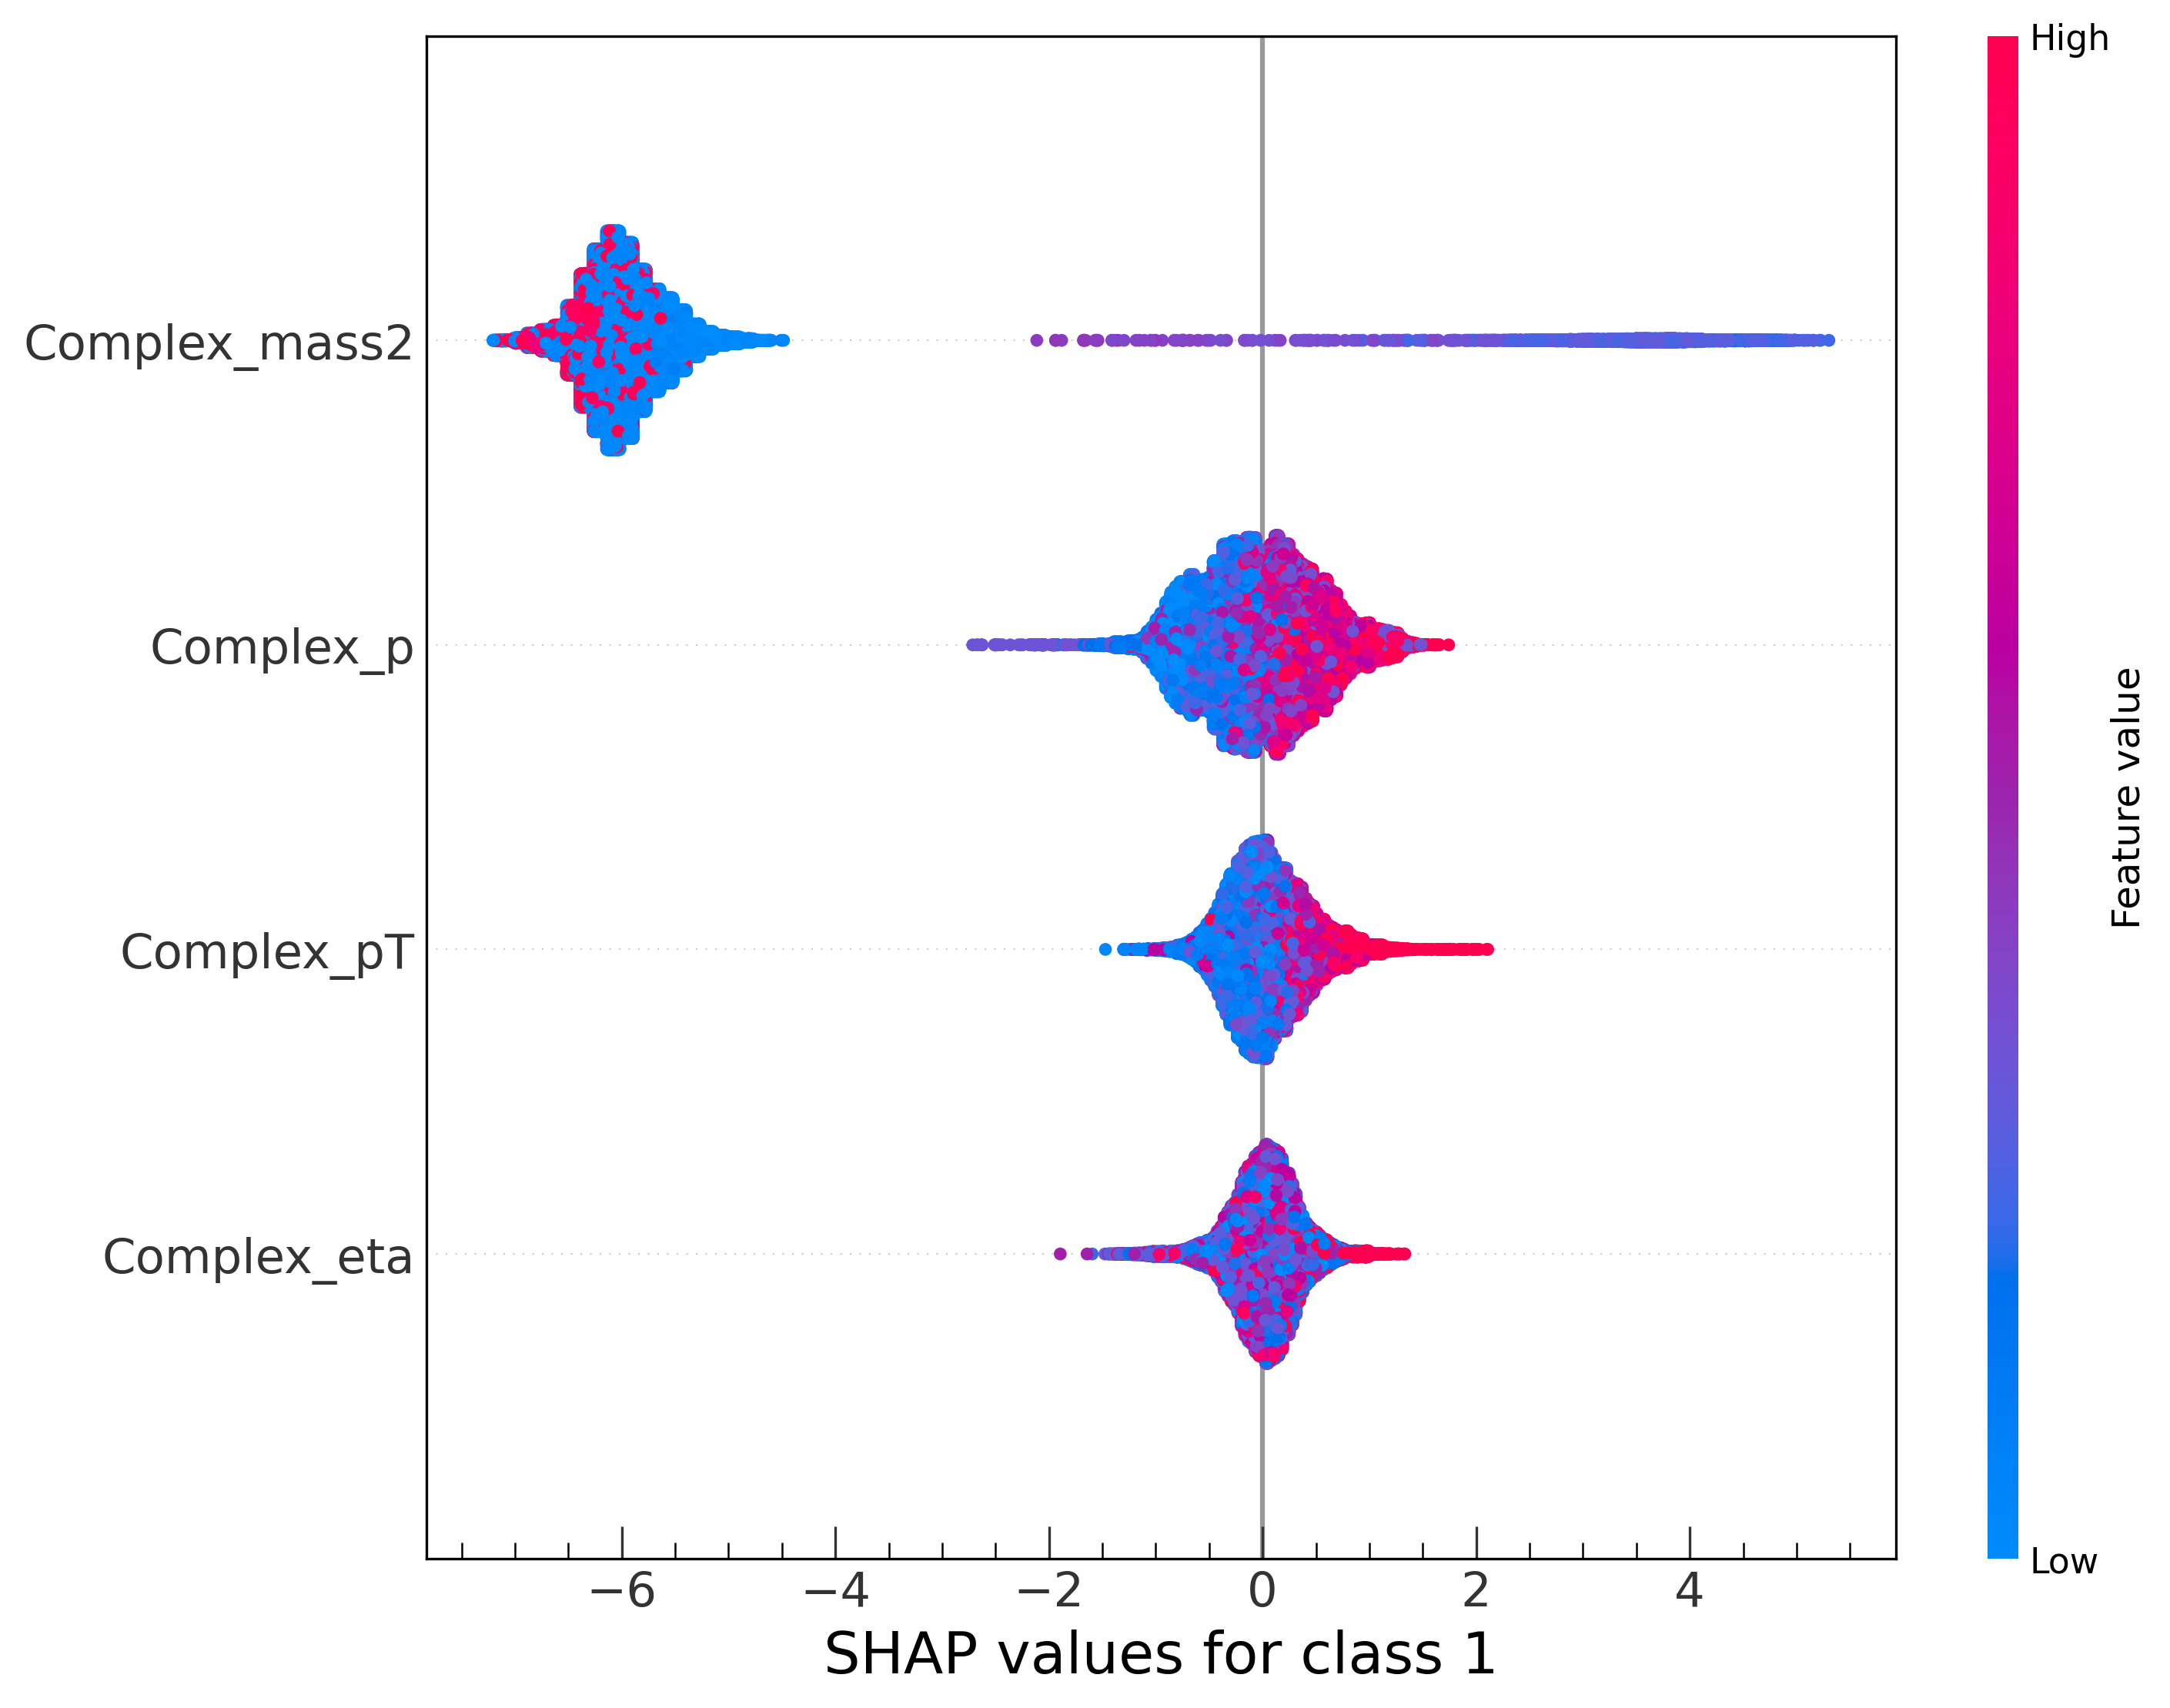

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


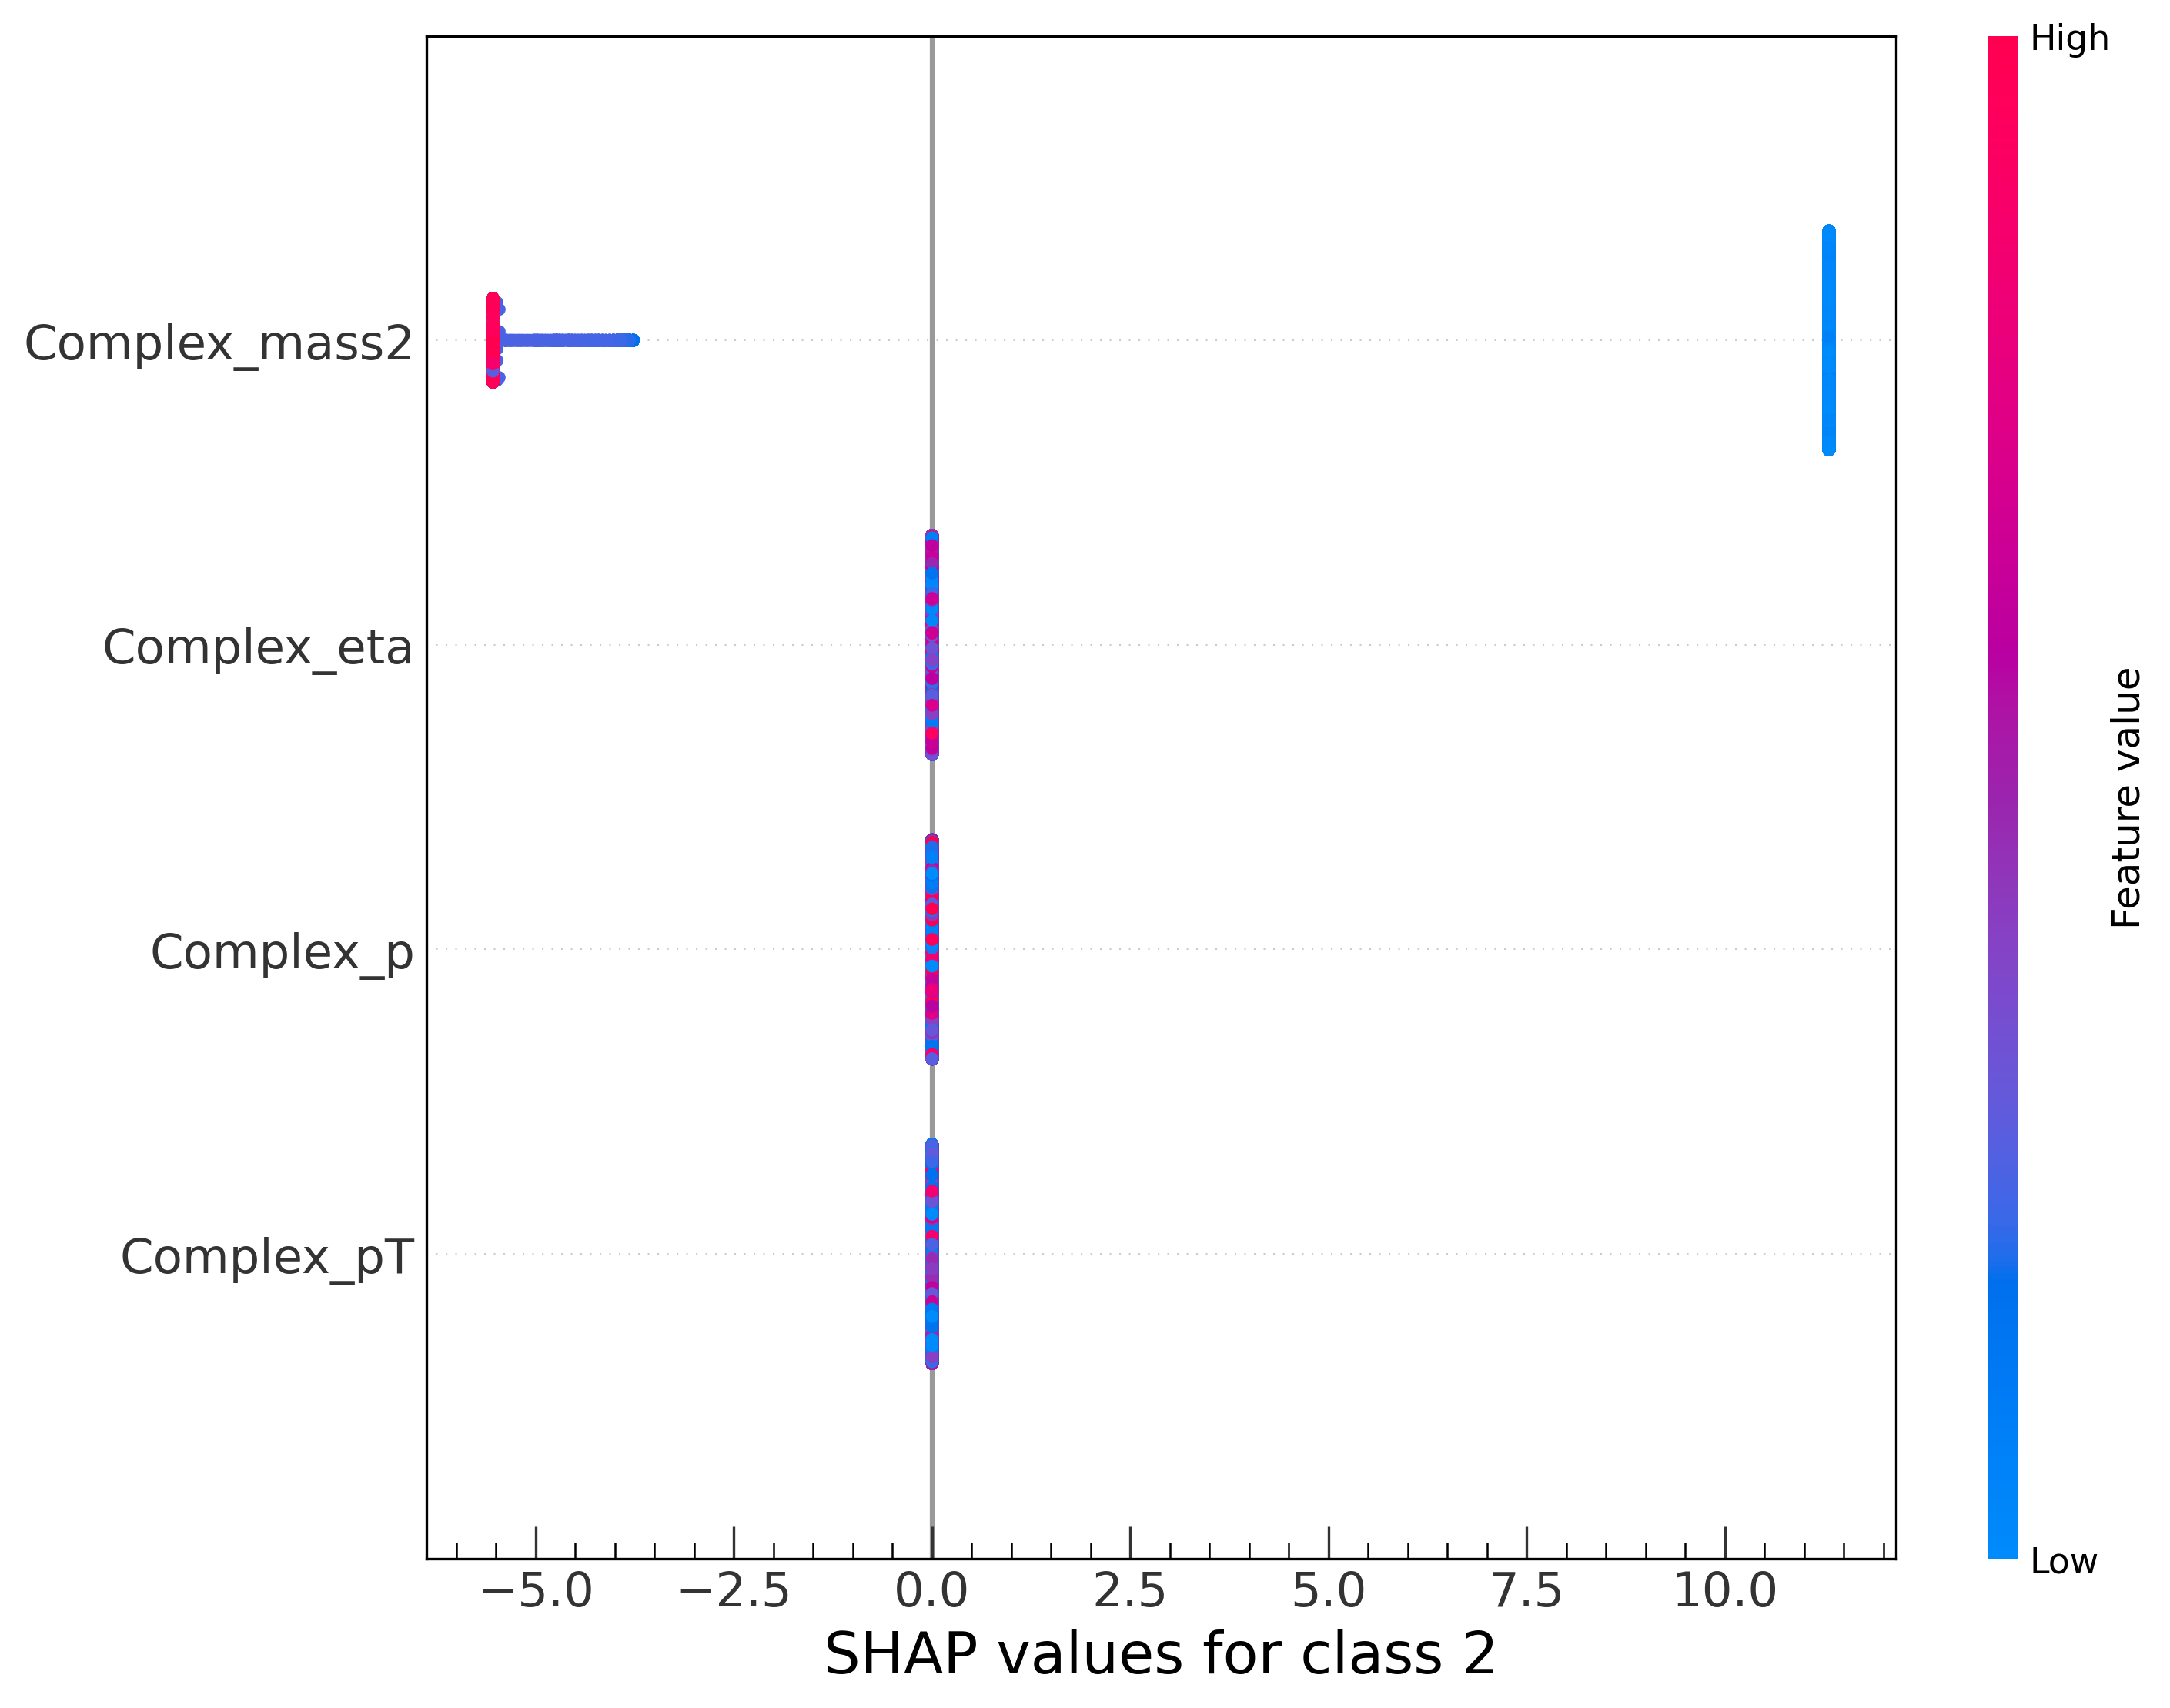

In [11]:
importlib.reload(plotting_tools)
plotting_tools.plot_shap_summary(
        train_test_data[2][features_for_train],
        y_pred_test,
        model_hdl
    )